In [ ]:
# Install required packages
!pip install sentencepiece datasets transformers
!pip install rouge-score nltk
!pip install psutil

In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import random
import os
import urllib.request
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import json
from collections import deque
import psutil
import time
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

In [ ]:
# Set device and random seeds
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!ls -lh qa_enhanced_model.pt

-rw-r--r-- 1 root root 820M Apr 27 15:35 qa_enhanced_model.pt


In [ ]:
# First install patool for archive extraction
!pip install patool
import patoolib

# Extract the ZIP contents
try:
    patoolib.extract_archive("qa_enhanced_model.pt", outdir="extracted_model")
    print("Extracted files:")
    !ls -lh extracted_model/
except Exception as e:
    print(f"Extraction failed: {e}")

INFO patool: Extracting qa_enhanced_model.pt ...
INFO:patool:Extracting qa_enhanced_model.pt ...
INFO patool: Different MIME types detected for qa_enhanced_model.pt: application/zip by file(1), None by extension. Preferring application/zip.
INFO:patool:Different MIME types detected for qa_enhanced_model.pt: application/zip by file(1), None by extension. Preferring application/zip.
INFO patool: running /usr/bin/7z x -aou -oextracted_model -- qa_enhanced_model.pt
INFO:patool:running /usr/bin/7z x -aou -oextracted_model -- qa_enhanced_model.pt
INFO patool: ... qa_enhanced_model.pt extracted to `extracted_model'.
INFO:patool:... qa_enhanced_model.pt extracted to `extracted_model'.


Extracted files:
total 4.0K
drwx------ 4 root root 4.0K Apr 27 18:45 qa_enhanced_model


In [ ]:
checkpoint = torch.load('qa_enhanced_model.pt', map_location=device)

In [ ]:
# 2. Second cell - Model Components
class Head(nn.Module):
    """One head of self-attention"""
    def __init__(self, head_size, n_embd, block_size, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """Simple linear layer followed by non-linearity"""
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
# Load your existing model and tokenizer
# (Assuming you have these files in your Colab environment)
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# Load tokenizer
!mkdir -p sp_model
sp = spm.SentencePieceProcessor()
sp.load('sp_model/sp_tokenizer.model')

# Load model
class QAEnhancedGPT(nn.Module):
    """Your existing model class"""
    def __init__(self, vocab_size, sp_processor=None, n_embd=384, n_head=6, n_layer=6, block_size=1024, dropout=0.2):
        super().__init__()
        self.n_embd = n_embd
        self.block_size = block_size
        self.sp = sp_processor
        self.assistant_start_token = sp_processor.piece_to_id('<ASSISTANT>')
        self.user_start_token = sp_processor.piece_to_id('<USER>')
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[
            Block(n_embd, n_head=n_head, block_size=block_size, dropout=dropout)
            for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, return_hidden=False):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb[None, ...]

        hidden_states = self.blocks(x)  # Get hidden states from transformer blocks
        x = self.ln_f(hidden_states)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        if return_hidden:
            return logits, loss, hidden_states
        return logits, loss

    def generate(self, idx, max_new_tokens=100, temperature=1.0, top_k=None, top_p=0.9):
        """Generate text with the model"""
        # Get special token IDs
        user_token_id = self.sp.piece_to_id('<USER>')
        assistant_token_id = self.sp.piece_to_id('<ASSISTANT>')
        assistant_end_token_id = self.sp.piece_to_id('</ASSISTANT>')

        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]

            # Get the predictions
            logits, _ = self(idx_cond)

            # Focus only on the last time step
            logits = logits[:, -1, :] / temperature

            # Apply top-k filtering if specified
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Apply nucleus (top-p) sampling if specified
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = -float('Inf')

            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)

            # Early stopping conditions
            if idx_next.item() == assistant_end_token_id:
                break
            if idx_next.item() == user_token_id:  # New user turn
                break

        return idx

# Initialize model
checkpoint = torch.load('qa_enhanced_model.pt')
model = QAEnhancedGPT(
    vocab_size=checkpoint['vocab_size'],
    sp_processor=sp,
    n_embd=checkpoint['n_embd'],
    n_head=checkpoint['n_head'],
    n_layer=checkpoint['n_layer'],
    block_size=checkpoint['block_size'],
    dropout=0.1
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

File ‘input.txt’ already there; not retrieving.



In [ ]:
class RewardModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Determine hidden size based on model type
        if hasattr(base_model, 'n_embd'):  # For custom QAEnhancedGPT
            hidden_size = base_model.n_embd
        elif hasattr(base_model, 'config'):  # For Hugging Face models
            hidden_size = base_model.config.hidden_size
        else:
            # Default size if neither attribute is found
            hidden_size = 768
            print("Warning: Could not determine hidden size, using default 768")

        # Simple reward head
        self.reward_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids):
        # Handle different model types
        with torch.no_grad():
            if hasattr(self.base_model, 'return_hidden') or isinstance(self.base_model, QAEnhancedGPT):
                # Your custom model
                _, _, hidden_states = self.base_model(input_ids, return_hidden=True)
                last_hidden = hidden_states[:, -1, :]
            else:
                # HuggingFace model
                outputs = self.base_model(input_ids, output_hidden_states=True)
                # Get last layer's hidden states
                hidden_states = outputs.hidden_states[-1]
                # Get last token's hidden state
                last_hidden = hidden_states[:, -1, :]

        # Compute reward
        reward = self.reward_head(last_hidden)
        return reward.squeeze(-1)

In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# import torch

# # Load QA evaluation model (using a QA quality assessment model)
# model_name = "microsoft/deberta-v3-base"  # or "deepset/deberta-v3-base-squad2" for QA specific
# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
# model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base").to(device)

In [ ]:
# from transformers import AutoModelForCausalLM

# # Change the model to a generative model like GPT-2 or similar
# model_name = "gpt2" # or another generative model
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification

# Generation model (e.g., GPT-2)
gen_model_name = "gpt2"
gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForCausalLM.from_pretrained(gen_model_name).to(device)

# Scoring model (e.g., DeBERTa for classification)
score_model_name = "microsoft/deberta-v3-base"
score_tokenizer = AutoTokenizer.from_pretrained(score_model_name)
score_model = AutoModelForSequenceClassification.from_pretrained(score_model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

In [ ]:
def score_response(prompt, response, model=score_model, tokenizer=score_tokenizer):
    # Combine prompt and response
    input_text = f"Question: {prompt}\nAnswer: {response}"

    # Tokenize
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Return the positive class score (for binary classification)
    return scores[0][1].item()

In [ ]:
def collect_human_feedback(model, sp_processor, num_samples=20):
    feedback_data = []
    sample_prompts = [
        "What are the main themes in Hamlet?",
        "Who wrote Pride and Prejudice?",
        "Explain the character of Macbeth",
        "What makes Wuthering Heights a gothic novel?",
        "How does Dickens use symbolism?"
    ] * 4  # Repeat to get enough samples

    for prompt in sample_prompts[:num_samples]:
        responses = []
        for _ in range(3):  # Generate 3 responses per prompt
            # Use your model's native input format
            input_text = f"<USER>{prompt}</USER><ASSISTANT>"

            # If using your custom model:
            if isinstance(model, QAEnhancedGPT):
                input_ids = torch.tensor([sp_processor.encode(input_text)], dtype=torch.long, device=device)
                output_ids = model.generate(input_ids, max_new_tokens=100)
                response_text = sp_processor.decode(output_ids[0].tolist())

            # If using HuggingFace models:
            else:
                # Use the gen_tokenizer associated with the generation model
                inputs = gen_tokenizer(input_text, return_tensors="pt").to(device)
                output_ids = model.generate(
                    **inputs,
                    max_new_tokens=100,
                    pad_token_id=gen_tokenizer.eos_token_id  # Use the tokenizer's eos_token_id
                )
                response_text = gen_tokenizer.decode(output_ids[0], skip_special_tokens=False)

            # Extract the response part
            try:
                response = response_text.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
            except:
                response = "Error extracting response"

            responses.append(response)

        # Use length as a simple ranking heuristic
        ranked = sorted(responses, key=lambda x: len(x), reverse=True)
        feedback_data.append({
            'prompt': prompt,
            'responses': responses,
            'rankings': [responses.index(r) for r in ranked]  # 0=best, 2=worst
        })

    return feedback_data

In [ ]:
def train_reward_model(reward_model, feedback_data, tokenizer, epochs=15):
    """Train the reward model on human feedback data"""
    optimizer = torch.optim.AdamW(reward_model.parameters(), lr=1e-5)
    loss_fn = nn.MarginRankingLoss(margin=1.0)

    for epoch in range(epochs):
        total_loss = 0
        for item in feedback_data:
            prompt = item['prompt']
            responses = item['responses']
            rankings = item['rankings']

            # We need to compute rewards for each response separately
            for i in range(len(responses)):
                for j in range(i+1, len(responses)):
                    if rankings[i] < rankings[j]:  # i is better than j
                        # Compute rewards for each response
                        text_i = f"<USER>{prompt}</USER><ASSISTANT>{responses[i]}</ASSISTANT>"
                        text_j = f"<USER>{prompt}</USER><ASSISTANT>{responses[j]}</ASSISTANT>"

                        input_ids_i = torch.tensor([tokenizer.encode(text_i)], dtype=torch.long, device=device)
                        input_ids_j = torch.tensor([tokenizer.encode(text_j)], dtype=torch.long, device=device)

                        # Forward pass to get rewards
                        reward_i = reward_model(input_ids_i)
                        reward_j = reward_model(input_ids_j)

                        # Target: reward_i should be greater than reward_j
                        target = torch.tensor([1.0], device=device)

                        # Calculate loss
                        pair_loss = loss_fn(reward_i, reward_j, target)

                        # Backpropagation
                        optimizer.zero_grad()
                        pair_loss.backward()
                        optimizer.step()

                        total_loss += pair_loss.item()

        avg_loss = total_loss / (len(feedback_data) * 3)  # Approximate number of pairs
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")

In [ ]:
reward_model = RewardModel(model).to(device)
feedback_data = collect_human_feedback(model, sp)
train_reward_model(reward_model, feedback_data, sp)

Epoch 1, Loss: 0.4508431921402613
Epoch 2, Loss: 0.4602927138408025
Epoch 3, Loss: 0.43096225957075757
Epoch 4, Loss: 0.4460196018218994
Epoch 5, Loss: 0.4564518471558889
Epoch 6, Loss: 0.4329243073860804
Epoch 7, Loss: 0.4152526448170344
Epoch 8, Loss: 0.4173947870731354
Epoch 9, Loss: 0.412622399131457
Epoch 10, Loss: 0.39026829500993093
Epoch 11, Loss: 0.41484443545341493
Epoch 12, Loss: 0.41232422391573587
Epoch 13, Loss: 0.3902324507633845
Epoch 14, Loss: 0.357116824388504
Epoch 15, Loss: 0.3844306399424871


In [ ]:
# 1. Before starting RL training, create a copy of your base model
# This should be done once before your training loop starts
import copy

def create_reference_model(model):
    """Create a frozen copy of the model to serve as reference"""
    ref_model = copy.deepcopy(model)
    # Freeze the reference model
    for param in ref_model.parameters():
        param.requires_grad = False
    return ref_model

# Create reference model
ref_model = create_reference_model(model)
ref_model.to(device)
ref_model.eval()  # Set to evaluation mode

# 2. KL penalty function
def compute_kl_penalty(model, ref_model, input_ids):
    """Compute KL divergence between current policy and reference policy"""
    with torch.no_grad():
        ref_logits, _ = ref_model(input_ids)
        ref_probs = F.softmax(ref_logits, dim=-1)

    logits, _ = model(input_ids)
    log_probs = F.log_softmax(logits, dim=-1)

    # Calculate KL divergence
    kl = F.kl_div(log_probs, ref_probs, reduction='batchmean')
    return kl

In [ ]:
class PPOTrainer:
    def __init__(self, model, reward_model, tokenizer, clip_epsilon=0.2, gamma=0.99, lam=0.95):
        self.model = model
        self.reward_model = reward_model
        self.tokenizer = tokenizer
        self.clip_epsilon = clip_epsilon
        self.gamma = gamma
        self.lam = lam
        # Use a small learning rate
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=5e-7)

    def generate_trajectory(self, prompt, max_length=100):
        """Generate a trajectory and record all necessary data for PPO update"""
        # Encode the prompt
        input_text = f"<USER>{prompt}</USER><ASSISTANT>"
        input_ids = torch.tensor([self.tokenizer.encode(input_text)], dtype=torch.long, device=device)

        # Store trajectory components
        states = [input_ids.clone()]
        actions = []
        log_probs = []
        values = []
        rewards = []
        response_text = input_text

        # Generate up to max_length tokens
        for _ in range(max_length):
            # Forward pass through the model WITHOUT detaching from computation graph
            current_input = states[-1]
            with torch.no_grad():  # Use no_grad here just for inference
                logits, _ = self.model(current_input)
                value = self.reward_model(current_input).item()

                # Get distribution over next tokens
                next_token_logits = logits[0, -1, :] / 0.8  # temperature=0.8
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample next token
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Compute log prob of chosen action
                log_prob = F.log_softmax(next_token_logits, dim=-1)[next_token].item()

            # Store data
            actions.append(next_token.item())
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(0.0)  # Will update the last reward later

            # Update state
            new_state = torch.cat([current_input, next_token.unsqueeze(0)], dim=1)
            states.append(new_state)

            # Update response text
            response_text = self.tokenizer.decode(new_state[0].tolist())

            # Check for stop conditions
            if next_token.item() == self.tokenizer.piece_to_id('</ASSISTANT>'):
                break

            # Force longer responses (at least 5 tokens)
            if len(actions) < 5:
                continue

            # Check if we generated an end marker (., !, ?, etc.)
            if self.tokenizer.decode([next_token.item()]) in ['.', '!', '?']:
                if len(actions) >= 10:  # Only consider stopping if we have a reasonable response
                    if random.random() < 0.3:  # 30% chance to stop after a sentence
                        break

        # Extract the response part
        try:
            response = response_text.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0]
        except:
            response = "Error extracting response"

        # Compute final reward
        with torch.no_grad():
            final_reward = self.reward_model(states[-1]).item()
            rewards[-1] = final_reward  # Assign reward to the last action

        return {
            'prompt': prompt,
            'states': states,
            'actions': actions,
            'log_probs': log_probs,
            'values': values,
            'rewards': rewards,
            'response': response
        }

    def ppo_update(self, trajectory):
        """Perform PPO update using the collected trajectory"""
        try:
            # Extract data
            states = trajectory['states']
            actions = trajectory['actions']
            old_log_probs = trajectory['log_probs']
            rewards = trajectory['rewards']
            values = trajectory['values']

            if len(actions) < 2:
                print("Warning: Not enough tokens generated to perform PPO update")
                return 0.0, 0.0, 0.0

            # Convert to tensors
            actions_tensor = torch.tensor(actions, dtype=torch.long, device=device)
            old_log_probs_tensor = torch.tensor(old_log_probs, device=device)
            rewards_tensor = torch.tensor(rewards, device=device)
            values_tensor = torch.tensor(values, device=device)

            # Compute returns and advantages
            returns = []
            advantages = []
            gae = 0

            for i in reversed(range(len(rewards))):
                if i == len(rewards) - 1:
                    next_value = 0
                else:
                    next_value = values[i + 1]

                delta = rewards[i] + self.gamma * next_value - values[i]
                gae = delta + self.gamma * self.lam * gae

                returns.insert(0, gae + values[i])
                advantages.insert(0, gae)

            returns_tensor = torch.tensor(returns, device=device)
            advantages_tensor = torch.tensor(advantages, device=device)

            # Normalize advantages
            if len(advantages_tensor) > 1:
                advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

            # For each decision point in the trajectory
            total_policy_loss = 0
            total_value_loss = 0

            for t in range(min(len(actions), 20)):  # Limit to first 20 tokens to avoid memory issues
                # Get the state before action t was taken
                state_t = states[t]

                # Get new probabilities and value
                logits, _ = self.model(state_t)
                next_token_logits = logits[0, -1, :]
                new_log_probs = F.log_softmax(next_token_logits, dim=-1)

                # Get the log prob of the action that was actually taken
                action = actions_tensor[t]
                new_log_prob = new_log_probs[action]

                # Compute ratio and surrogate losses
                ratio = torch.exp(new_log_prob - old_log_probs_tensor[t])

                # Clip the ratio to prevent extreme updates
                ratio_clipped = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon)

                # Surrogate losses
                surrogate1 = ratio * advantages_tensor[t]
                surrogate2 = ratio_clipped * advantages_tensor[t]
                policy_loss = -torch.min(surrogate1, surrogate2)

                # Value loss
                # Get the predicted value for this state
                value_pred = self.reward_model(state_t)
                value_loss = F.mse_loss(value_pred, returns_tensor[t].unsqueeze(0))

                # Combine losses
                loss = policy_loss + 0.5 * value_loss

                # Backpropagate and update
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()

                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()

            # Calculate average losses
            avg_policy_loss = total_policy_loss / min(len(actions), 20)
            avg_value_loss = total_value_loss / min(len(actions), 20)
            total_loss = avg_policy_loss + 0.5 * avg_value_loss

            return total_loss, avg_policy_loss, avg_value_loss

        except Exception as e:
            print(f"Error in PPO update: {e}")
            import traceback
            traceback.print_exc()
            return 0.0, 0.0, 0.0

    def train(self, prompts, num_epochs=3):
        """Train the model using PPO on the given prompts"""
        for epoch in range(num_epochs):
            print(f"\n=== Starting Epoch {epoch+1}/{num_epochs} ===\n")
            total_loss = 0
            total_policy_loss = 0
            total_value_loss = 0
            successful_updates = 0
            generated_responses = []

            # Process each prompt
            for i, prompt in enumerate(prompts):
                print(f"\nEpoch {epoch+1}, Processing prompt {i+1}/{len(prompts)}: '{prompt}'")

                # Generate trajectory
                trajectory = self.generate_trajectory(prompt)

                # Store response
                generated_responses.append({
                    'prompt': prompt,
                    'response': trajectory['response']
                })

                print(f"Generated response: {trajectory['response']}")
                print(f"Tokens generated: {len(trajectory['actions'])}")

                # Update model
                if len(trajectory['actions']) >= 2:
                    loss, policy_loss, value_loss = self.ppo_update(trajectory)

                    total_loss += loss
                    total_policy_loss += policy_loss
                    total_value_loss += value_loss
                    successful_updates += 1

                    print(f"PPO update - Loss: {loss:.4f}, Policy Loss: {policy_loss:.4f}, Value Loss: {value_loss:.4f}")
                else:
                    print("Not enough tokens for PPO update")

            # Print epoch summary
            if successful_updates > 0:
                avg_loss = total_loss / successful_updates
                avg_policy_loss = total_policy_loss / successful_updates
                avg_value_loss = total_value_loss / successful_updates

                print(f"\n=== Epoch {epoch+1} Summary ===")
                print(f"  Average Loss: {avg_loss:.4f}")
                print(f"  Average Policy Loss: {avg_policy_loss:.4f}")
                print(f"  Average Value Loss: {avg_value_loss:.4f}")
                print(f"  Successful Updates: {successful_updates}/{len(prompts)}")

                # Print sample response
                if generated_responses:
                    print("\nSample response from this epoch:")
                    sample_idx = random.randint(0, len(generated_responses)-1)
                    print(f"Prompt: {generated_responses[sample_idx]['prompt']}")
                    print(f"Response: {generated_responses[sample_idx]['response']}")
            else:
                print("\n=== No successful updates in this epoch ===")

            print("="*50)

        return generated_responses

      # 3. Modified PPO train step with KL penalty
    def ppo_train_step_with_kl(rl_wrapper, optimizer, input_ids, logits, hidden,
                              ref_model, clip_epsilon=0.2, kl_coef=0.1):
        """PPO training step with KL penalty to prevent model drift"""
        try:
            with torch.no_grad():
                ref_logits = ref_model(input_ids)[0]
                ref_probs = F.softmax(ref_logits[:, -1, :], dim=-1)

            probs = F.softmax(logits[:, -1, :], dim=-1)
            dist = torch.distributions.Categorical(probs)
            actions = dist.sample()

            # Get reward
            rewards = rl_wrapper.reward_model(hidden)

            # Calculate KL divergence penalty (add this part)
            kl_penalty = F.kl_div(
                F.log_softmax(logits, dim=-1),
                F.softmax(ref_logits, dim=-1),
                reduction='batchmean'
            )

            # Apply KL penalty to rewards
            penalized_rewards = rewards - kl_coef * kl_penalty.unsqueeze(1)

            # Continue with standard PPO calculation
            advantages = (penalized_rewards - penalized_rewards.mean()) / (penalized_rewards.std(unbiased=False) + 1e-7)

            ratio = torch.exp(dist.log_prob(actions) - torch.log(ref_probs.gather(1, actions.unsqueeze(1)).squeeze()))
            clipped_ratio = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon)
            policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()

            optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(rl_wrapper.parameters(), 1.0)
            optimizer.step()

            return policy_loss.item(), kl_penalty.item()
        except Exception as e:
            print(f"Error in PPO training step: {e}")
            return None, None

In [ ]:
# 2. PPO Implementation - Training
training_prompts = [
    "What are the main themes in Hamlet?",
    "Who wrote Pride and Prejudice?",
    "Explain the character of Macbeth",
    "What makes Wuthering Heights a gothic novel?",
    "How does Dickens use symbolism?"
]

ppo_trainer = PPOTrainer(model, reward_model, sp)
ppo_trainer.train(training_prompts, num_epochs=15)


=== Starting Epoch 1/15 ===


Epoch 1, Processing prompt 1/5: 'What are the main themes in Hamlet?'
Generated response: “No now found it is a man. Knightley have sung quite agree.... Miss Fairfax said Mr.
Tokens generated: 20
PPO update - Loss: 0.0864, Policy Loss: 0.0699, Value Loss: 0.0332

Epoch 1, Processing prompt 2/5: 'Who wrote Pride and Prejudice?'
Generated response: When the staff
Tokens generated: 4
PPO update - Loss: 0.0206, Policy Loss: -0.0382, Value Loss: 0.1176

Epoch 1, Processing prompt 3/5: 'Explain the character of Macbeth'
Generated response: The offend _through_ the morning, crouching in the means, then has been happy and breaking. Now, that there was the morning, and Nicholas, and we tumbler in the weighing in the Rostóvs’s death have recalled the doctor, with aM, "Irreplaceable", immediately tea with a hand, making her hand.
Tokens generated: 66
PPO update - Loss: -0.1521, Policy Loss: -0.1639, Value Loss: 0.0236

Epoch 1, Processing prompt 4/5: 'What makes Wut

[{'prompt': 'What are the main themes in Hamlet?',
  'response': '“How do for_ take them here!” following kiss till Miss Lucas, for ever thought us alone; “What gothic elements are present in Wuthering Heights?'},
 {'prompt': 'Who wrote Pride and Prejudice?',
  'response': 'When the gentlemen rose to go away, who had been captured that Barnard'},
 {'prompt': 'Explain the character of Macbeth',
  'response': '“I come to dispel your own way, why don’t stop dat dam racket!”'},
 {'prompt': 'What makes Wuthering Heights a gothic novel?',
  'response': '“The release had better go into lay! Why--a strong terriKING RICHARD II: but thinking of a low brow with him, and we are present in literature?'},
 {'prompt': 'How does Dickens use symbolism?',
  'response': '“And I have not now cannot wonder at that that told the army too late and I shall find a dead head over him that, introducing himself by a friend will be ingrate.'}]

In [ ]:
ppo_model_path = 'ppo_enhanced_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': checkpoint['vocab_size'],
    'n_embd': checkpoint['n_embd'],
    'n_head': checkpoint['n_head'],
    'n_layer': checkpoint['n_layer'],
    'block_size': checkpoint['block_size'],
    'tokenizer_path': 'sp_model/sp_tokenizer.model'
}, ppo_model_path)
print(f"PPO-enhanced model saved to {ppo_model_path}")

PPO-enhanced model saved to ppo_enhanced_model.pt


In [ ]:
class SimpleRLHF:
    """A simplified RLHF implementation focused on stable training"""

    def __init__(self, model, reward_model, tokenizer, learning_rate=1e-6):
        self.model = model
        self.reward_model = reward_model
        self.tokenizer = tokenizer
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    def train_step(self, prompt, verbose=True):
        """Perform a single RLHF training step on one prompt"""

        # 1. Generate a response with the current model
        if verbose:
            print(f"Processing prompt: {prompt}")

        # Tokenize input
        input_text = f"<USER>{prompt}</USER><ASSISTANT>"
        input_ids = torch.tensor([self.tokenizer.encode(input_text)], dtype=torch.long, device=device)

        # Generate response with the model (use inference mode to save memory)
        with torch.no_grad():
            generated_ids = self.model.generate(input_ids.clone(), max_new_tokens=100, temperature=1.0)

        # Extract the response text
        response_text = self.tokenizer.decode(generated_ids[0].tolist())
        try:
            response = response_text.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
        except:
            response = "Error extracting response"

        if verbose:
            print(f"Generated response: {response}")

        # 2. Compute reward for this response
        with torch.no_grad():
            full_text = f"<USER>{prompt}</USER><ASSISTANT>{response}</ASSISTANT>"
            reward_input_ids = torch.tensor([self.tokenizer.encode(full_text)], dtype=torch.long, device=device)
            reward = self.reward_model(reward_input_ids).item()

        if verbose:
            print(f"Reward: {reward:.4f}")

        # 3. Generate a second response with a slight variation and get reward
        with torch.no_grad():
            generated_ids2 = self.model.generate(input_ids.clone(), max_new_tokens=100, temperature=1.2)

        response_text2 = self.tokenizer.decode(generated_ids2[0].tolist())
        try:
            response2 = response_text2.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
        except:
            response2 = "Error extracting second response"

        if verbose:
            print(f"Second response: {response2}")

        with torch.no_grad():
            full_text2 = f"<USER>{prompt}</USER><ASSISTANT>{response2}</ASSISTANT>"
            reward_input_ids2 = torch.tensor([self.tokenizer.encode(full_text2)], dtype=torch.long, device=device)
            reward2 = self.reward_model(reward_input_ids2).item()

        if verbose:
            print(f"Second reward: {reward2:.4f}")

        # 4. Determine which response is better
        if reward > reward2:
            better_response = response
            better_ids = generated_ids
            better_reward = reward
        else:
            better_response = response2
            better_ids = generated_ids2
            better_reward = reward2

        if verbose:
            print(f"Better reward: {better_reward:.4f}")

        # 5. Update the model to increase probability of the better response
        # IMPORTANT: Need to do a NEW forward pass that creates a computational graph
        better_text = f"<USER>{prompt}</USER><ASSISTANT>{better_response}</ASSISTANT>"
        better_input_ids = torch.tensor([self.tokenizer.encode(better_text)], dtype=torch.long, device=device)

        # Forward pass WITH gradient tracking
        logits, _ = self.model(better_input_ids)

        # Focus on the assistant's response tokens (excluding prompt)
        assistant_token_id = self.tokenizer.piece_to_id('<ASSISTANT>')
        assistant_pos = (better_input_ids == assistant_token_id).nonzero(as_tuple=True)[1][0]

        # Get last-token prediction for all assistant response positions
        relevant_logits = logits[:, assistant_pos:-1, :]  # exclude the last token's prediction

        # Get the actual next tokens for the assistant's response
        actual_next_tokens = better_input_ids[:, assistant_pos+1:]

        # Compute log probabilities of the chosen tokens
        log_probs = F.log_softmax(relevant_logits, dim=-1)
        token_log_probs = torch.gather(
            log_probs,
            2,
            actual_next_tokens.unsqueeze(-1)
        ).squeeze(-1)

        # Policy gradient loss: maximize log prob * reward
        loss = -(token_log_probs.mean() * better_reward)

        # Backpropagate
        self.optimizer.zero_grad()
        loss.backward()

        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return {
            'response': response,
            'response2': response2,
            'reward': reward,
            'reward2': reward2,
            'loss': loss.item()
        }

    def train(self, prompts, iterations=5, verbose=True):
        """Train on a set of prompts for multiple iterations"""
        results = []

        for iteration in range(iterations):
            print(f"\n=== Iteration {iteration+1}/{iterations} ===\n")
            iteration_results = []

            for i, prompt in enumerate(prompts):
                print(f"\nPrompt {i+1}/{len(prompts)}")
                try:
                    result = self.train_step(prompt, verbose=verbose)
                    iteration_results.append(result)
                    print(f"Loss: {result['loss']:.6f}")
                except Exception as e:
                    print(f"Error during training step: {e}")
                    continue

            # Compute average reward if we have results
            if iteration_results:
                avg_reward = sum(r['reward'] for r in iteration_results) / len(iteration_results)
                print(f"\n=== Iteration {iteration+1} completed ===")
                print(f"Average reward: {avg_reward:.4f}")

                results.append({
                    'iteration': iteration+1,
                    'avg_reward': avg_reward,
                    'results': iteration_results
                })
            else:
                print("\n=== Iteration failed - no successful training steps ===")

        return results

In [ ]:
# Initialize the simple RLHF trainer
simple_rlhf = SimpleRLHF(model, reward_model, sp)

# Train using the same prompts
results = simple_rlhf.train(training_prompts, iterations=5)


=== Iteration 1/5 ===


Prompt 1/5
Processing prompt: What are the main themes in Hamlet?
Generated response: “How do no! take me and turn me to turn; “ brightness, when we is a low lit up when I was happy and Lady Catherine. Roylott returned, he breathed before I.
Reward: -0.0740
Second response: “Yes,” said Mr. There would consider all be slowly lost, reestablished in which now, when I had already gone to visit,—“ oft- seas, “heHad I may have a Express and says: did my let out his shoulder. Fairfax said Herbert is coming over to know too, I liked it’s well and departed. Cetus is most ready for our mama
Second reward: 0.0330
Better reward: 0.0330
Error during training step: element 0 of tensors does not require grad and does not have a grad_fn

Prompt 2/5
Processing prompt: Who wrote Pride and Prejudice?
Generated response: When the has!
Reward: -0.2580
Second response: When the afternoon, in ...
Second reward: -0.2712
Better reward: -0.2580
Error during training step: element 0 of t

In [ ]:
# 3. Constitutional AI Implementation
class ConstitutionalAI:
    def __init__(self, model, tokenizer, constitution_file='constitution.json'):
        self.model = model
        self.tokenizer = tokenizer
        self.constitution = self.load_constitution(constitution_file)

    def load_constitution(self, filename):
        default_constitution = {
            "principles": [
                "Always provide accurate information about literature",
                "Never generate harmful or offensive content",
                "Maintain an academic tone in responses",
                "Cite sources when possible",
                "Acknowledge when you don't know something",
                "Avoid making subjective judgments about authors",
                "Focus on factual literary analysis"
            ],
            "critique_prompts": {
                "accuracy": "Does this response contain factually accurate information?",
                "safety": "Could this response be considered harmful or offensive?",
                "tone": "Is the tone appropriate for academic discussion?",
                "completeness": "Does the response fully address the question?"
            }
        }

        try:
            with open(filename, 'r') as f:
                return json.load(f)
        except:
            return default_constitution

    def generate_with_critique(self, prompt, max_length=100, temperature=0.7):
        # First generate initial response
        input_ids = torch.tensor([self.tokenizer.encode(
            f"<USER>{prompt}</USER><ASSISTANT>")], dtype=torch.long, device=device)
        output_ids = self.model.generate(input_ids, max_new_tokens=max_length, temperature=temperature)
        initial_response = self.tokenizer.decode(output_ids[0].tolist())
        initial_response = initial_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0]

        # Generate critiques
        critiques = []
        for aspect, critique_prompt in self.constitution['critique_prompts'].items():
            critique_input = f"<USER>Response to critique: {initial_response}\n\n{critique_prompt}</USER><ASSISTANT>"
            critique_ids = torch.tensor([self.tokenizer.encode(critique_input)], dtype=torch.long, device=device)
            critique_output = self.model.generate(critique_ids, max_new_tokens=50, temperature=0.3)
            critique = self.tokenizer.decode(critique_output[0].tolist())
            critique = critique.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0]
            critiques.append((aspect, critique))

        # Generate revised response
        revision_prompt = f"<USER>Original response: {initial_response}\n\nCritiques:\n"
        for aspect, critique in critiques:
            revision_prompt += f"- {aspect}: {critique}\n"
        revision_prompt += "\nPlease generate an improved response that addresses these critiques.</USER><ASSISTANT>"

        revision_ids = torch.tensor([self.tokenizer.encode(revision_prompt)], dtype=torch.long, device=device)
        revised_output = self.model.generate(revision_ids, max_new_tokens=max_length, temperature=temperature)
        revised_response = self.tokenizer.decode(revised_output[0].tolist())
        revised_response = revised_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0]

        return {
            'initial_response': initial_response,
            'critiques': critiques,
            'revised_response': revised_response
        }

In [ ]:
# 3. Constitutional AI - Testing
constitutional_ai = ConstitutionalAI(model, sp)

# Test with a sample prompt
result = constitutional_ai.generate_with_critique("What are the main themes in Hamlet?")
print("\n=== Initial Response ===")
print(result['initial_response'])
print("\n=== Critiques ===")
for aspect, critique in result['critiques']:
    print(f"{aspect.upper()}: {critique}")
print("\n=== Revised Response ===")
print(result['revised_response'])


=== Initial Response ===
“How do not wonder at the officer in, then here at me and it is a smile. Dismounting at a cottage on whose wattle fence hung a signboard, GENERAL STAFF, and throwing down his reins, he entered a dark passage.

=== Critiques ===
ACCURACY: “‘Yes, he flung it you must tell me no difference between the group of faces.
SAFETY: “I am no longer ago you,” said he pleaded.
TONE: The man, for a word can stay.
COMPLETENESS: Elizabeth made no attempt to the product and autumn night’t night?”

=== Revised Response ===
First two would never felt it is atrocious—H. “What are the Holy Father, and he scarce, if need ...


In [ ]:
def save_enhanced_model(model, reward_model, tokenizer, filename='enhanced_qa_model.pt'):
    # The tokenizer attributes should be accessed as parameters
    # And we need to store the path to the tokenizer
    torch.save({
        'model_state_dict': model.state_dict(),
        'reward_model_state_dict': reward_model.state_dict(),
        # Store the path to the tokenizer model
        'tokenizer_path': 'sp_model/sp_tokenizer.model',
        # Access these as parameters of the model instead of attributes
        'vocab_size': len(tokenizer),  # Get vocab size from tokenizer
        'block_size': model.block_size,  # This is an attribute
        'n_embd': model.n_embd,  # This is an attribute
        'n_head': model.n_head,  # This needs to be from model params
        'n_layer': model.n_layer,  # This needs to be from model params
        'constitution': constitutional_ai.constitution
    }, filename)

In [ ]:
# Interactive Chat with Enhanced Model
def chat_with_model(model, tokenizer, max_tokens=100, temperature=0.7):
    print("\n🤖 QA-Enhanced Literary Assistant 🤖")
    print("Type 'exit' to end the conversation.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("\nGoodbye!")
            break

        # Generate response with Constitutional AI
        result = constitutional_ai.generate_with_critique(
            user_input,
            max_length=max_tokens,
            temperature=temperature
        )

        print("\nAI Response:")
        print(result['revised_response'])
        print("\n---\n")

# Start chat
chat_with_model(model, sp)


🤖 QA-Enhanced Literary Assistant 🤖
Type 'exit' to end the conversation.

You: whate are the main themes of hamlet

AI Response:
Second Murderer: He...

---

You: where is taj mahal

AI Response:
“I like a great forefinger as he warn’t for eleven consecutive number-language...', How old man-tending anthems such a honest how in the morning we would detain me ever see any prior, too dear! When he is the group is too late 1990s Child.

---

You: where is taj mahal

AI Response:
“Given this context: 'In an interview published by a variety of the MTV Awards in the latter, "the definition music video campaign, and produced a man who performed, drummers, which would never started in the act of a man-day feminist

---

You: exit

Goodbye!


In [ ]:
# Benchmark Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import psutil
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Ensure we have the necessary packages
!pip install -q rouge_score nltk
import nltk
nltk.download('punkt', quiet=True)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def benchmark_generation_speed(model, tokenizer, prompt="<USER>Tell me about Pride and Prejudice</USER><ASSISTANT>",
                             num_runs=3, max_tokens=50):
    """
    Benchmark how fast the model generates text
    Returns:
        - avg_time: Average time per generation in seconds
        - tokens_per_sec: Average generation speed in tokens/second
    """
    model.eval()
    device = next(model.parameters()).device

    # Encode the prompt
    tokens = tokenizer.encode(prompt)
    input_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

    # Warmup
    with torch.no_grad():
        _ = model.generate(input_tensor, max_new_tokens=10)

    # Benchmark
    generation_times = []
    generated_lengths = []
    memory_usages = []

    for _ in range(num_runs):
        # Monitor memory
        if device == 'cuda':
            torch.cuda.empty_cache()
            mem_before = torch.cuda.memory_allocated() / (1024**2)  # MB
        else:
            process = psutil.Process()
            mem_before = process.memory_info().rss / (1024**2)  # MB

        start_time = time.time()
        with torch.no_grad():
            output_ids = model.generate(input_tensor, max_new_tokens=max_tokens)[0].tolist()
        end_time = time.time()

        # Check memory again
        if device == 'cuda':
            mem_after = torch.cuda.memory_allocated() / (1024**2)  # MB
        else:
            mem_after = process.memory_info().rss / (1024**2)  # MB

        generation_time = end_time - start_time
        generated_length = len(output_ids) - len(tokens)
        memory_used = max(0, mem_after - mem_before)  # Avoid negative values

        generation_times.append(generation_time)
        generated_lengths.append(generated_length)
        memory_usages.append(memory_used)

    avg_time = np.mean(generation_times)
    avg_tokens = np.mean(generated_lengths)
    tokens_per_sec = avg_tokens / avg_time
    avg_memory = np.mean(memory_usages)

    print(f"Average generation time for {max_tokens} tokens: {avg_time:.4f} sec")
    print(f"Average generation speed: {tokens_per_sec:.2f} tokens/sec")
    print(f"Average memory usage: {avg_memory:.2f} MB")

    return avg_time, tokens_per_sec, avg_memory

In [ ]:
def benchmark_response_quality(model, tokenizer, test_pairs):
    """
    Evaluate model response quality using BLEU and ROUGE metrics
    Returns:
        - bleu_scores: List of BLEU scores for each test pair
        - rouge_scores: List of ROUGE-L scores for each test pair
    """
    model.eval()
    device = next(model.parameters()).device
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    bleu_scores = []
    rouge_scores = []
    results = []

    for i, (question, reference) in enumerate(test_pairs):
        # Format prompt
        prompt = f"<USER>{question}</USER><ASSISTANT>"

        # Generate response
        input_ids = torch.tensor([tokenizer.encode(prompt)], device=device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_new_tokens=100,
                temperature=0.7,
                top_k=50
            )

        # Decode and extract response
        full_output = tokenizer.decode(output_ids[0].tolist())
        try:
            # Extract content between assistant tags
            response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
        except:
            # Fallback if tags are not properly closed
            response = full_output.split("<ASSISTANT>")[-1].strip()

        # Calculate metrics
        try:
            bleu = sentence_bleu([reference.split()], response.split())
        except:
            bleu = 0

        try:
            rouge = scorer.score(reference, response)['rougeL'].fmeasure
        except:
            rouge = 0

        bleu_scores.append(bleu)
        rouge_scores.append(rouge)

        # Store result
        results.append({
            'question': question,
            'reference': reference,
            'response': response,
            'bleu': bleu,
            'rouge': rouge
        })

    # Calculate averages
    avg_bleu = np.mean(bleu_scores)
    avg_rouge = np.mean(rouge_scores)

    print(f"Average BLEU score: {avg_bleu:.4f}")
    print(f"Average ROUGE-L score: {avg_rouge:.4f}")

    return results, avg_bleu, avg_rouge

In [ ]:
def benchmark_prompt_processing(model, tokenizer, prompts, num_runs=3):
    """
    Benchmark how quickly the model processes inputs (forward pass only)
    """
    model.eval()
    device = next(model.parameters()).device

    processing_times = []

    for prompt in prompts:
        # Encode the prompt
        tokens = tokenizer.encode(prompt)
        input_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

        # Benchmark forward pass times
        for _ in range(num_runs):
            if device == 'cuda':
                torch.cuda.synchronize()
            start_time = time.time()

            with torch.no_grad():
                _ = model(input_tensor)

            if device == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()

            processing_times.append(end_time - start_time)

    avg_processing_time = np.mean(processing_times)
    print(f"Average prompt processing time: {avg_processing_time:.4f} sec")
    return avg_processing_time

In [ ]:
def benchmark_coherence(model, tokenizer, prompts, max_tokens=200):
    """
    Test model coherence by generating longer responses
    """
    model.eval()
    device = next(model.parameters()).device

    outputs = []

    for prompt in prompts:
        formatted_prompt = f"<USER>{prompt}</USER><ASSISTANT>"
        input_ids = torch.tensor([tokenizer.encode(formatted_prompt)], device=device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_new_tokens=max_tokens,
                temperature=0.7,
                top_k=50,
                top_p=0.9
            )

        full_output = tokenizer.decode(output_ids[0].tolist())
        try:
            response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
        except:
            response = full_output.split("<ASSISTANT>")[-1].strip()

        outputs.append({
            'prompt': prompt,
            'response': response,
            'length': len(response)
        })

        print(f"Prompt: {prompt}")
        print(f"Response: {response}")
        print(f"Length: {len(response)} chars")
        print("-" * 50)

    return outputs

In [ ]:
def benchmark_qa_capabilities(model, tokenizer, qa_pairs):
    """
    Test model's ability to handle specific QA tasks
    """
    model.eval()
    device = next(model.parameters()).device

    results = []
    correct = 0

    for i, (context, question, answer) in enumerate(qa_pairs):
        # Format with context
        if context:
            prompt = f"<USER>Context: {context}\nQuestion: {question}</USER><ASSISTANT>"
        else:
            prompt = f"<USER>{question}</USER><ASSISTANT>"

        input_ids = torch.tensor([tokenizer.encode(prompt)], device=device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_new_tokens=50,
                temperature=0.7
            )

        full_output = tokenizer.decode(output_ids[0].tolist())
        try:
            response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
        except:
            response = full_output.split("<ASSISTANT>")[-1].strip()

        # Simple accuracy check - response contains the answer
        is_correct = answer.lower() in response.lower()
        if is_correct:
            correct += 1

        results.append({
            'context': context,
            'question': question,
            'expected': answer,
            'response': response,
            'correct': is_correct
        })

        print(f"Sample {i+1}: {'✓' if is_correct else '✗'}")
        print(f"Question: {question}")
        print(f"Response: {response}")
        print(f"Expected: {answer}")
        print("-" * 50)

    accuracy = correct / len(qa_pairs)
    print(f"QA Accuracy: {accuracy:.2f} ({correct}/{len(qa_pairs)})")

    return results, accuracy

In [ ]:
def visualize_benchmarks(speed_results, quality_results, qa_results, coherence_results):
    """
    Create visualizations of benchmark results
    """
    plt.figure(figsize=(15, 10))

    # Create a 2x2 subplot grid
    plt.subplot(2, 2, 1)
    plt.title('Generation Speed')
    plt.bar(['Tokens/sec'], [speed_results[1]], color='blue')
    plt.ylabel('Tokens per second')

    # Quality metrics plot
    plt.subplot(2, 2, 2)
    bleu_scores = [result['bleu'] for result in quality_results]
    rouge_scores = [result['rouge'] for result in quality_results]
    x = range(len(quality_results))
    plt.title('Response Quality')
    plt.bar([i-0.2 for i in x], bleu_scores, width=0.4, label='BLEU', color='green')
    plt.bar([i+0.2 for i in x], rouge_scores, width=0.4, label='ROUGE-L', color='orange')
    plt.xlabel('Test Case')
    plt.ylabel('Score')
    plt.legend()

    # QA accuracy plot
    plt.subplot(2, 2, 3)
    plt.title('QA Task Accuracy')
    correct = [1 if result['correct'] else 0 for result in qa_results[0]]
    plt.bar(range(len(correct)), correct, color=['green' if c else 'red' for c in correct])
    plt.xlabel('Test Case')
    plt.ylabel('Correct (1) / Incorrect (0)')
    plt.yticks([0, 1])

    # Response lengths plot
    plt.subplot(2, 2, 4)
    plt.title('Response Coherence (Length)')
    lengths = [result['length'] for result in coherence_results]
    plt.bar(range(len(lengths)), lengths, color='purple')
    plt.xlabel('Test Case')
    plt.ylabel('Response Length (chars)')

    plt.tight_layout()
    plt.savefig('rl_model_benchmarks.png')
    plt.show()

    # Additional radar chart for overall model performance
    categories = ['Speed', 'Quality', 'Accuracy', 'Coherence']
    # Normalize metrics to 0-1 scale
    speed_metric = min(1.0, speed_results[1] / 20)  # Tokens/sec normalized
    quality_metric = (np.mean(bleu_scores) + np.mean(rouge_scores)) / 2
    accuracy_metric = qa_results[1]  # Already 0-1
    coherence_metric = min(1.0, np.mean(lengths) / 500)  # Length normalized

    values = [speed_metric, quality_metric, accuracy_metric, coherence_metric]

    # Create radar chart
    plt.figure(figsize=(8, 8))
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # Close the loop
    angles += angles[:1]  # Close the loop
    categories += categories[:1]  # Close the loop

    plt.polar(angles, values, 'o-', linewidth=2)
    plt.fill(angles, values, alpha=0.25)
    plt.thetagrids(np.degrees(angles[:-1]), categories[:-1])
    plt.title('Model Performance Overview', size=15)
    plt.grid(True)

    plt.savefig('model_performance_radar.png')
    plt.show()

In [ ]:
# Define test data for benchmarks

# Sample prompts for speed and coherence tests
test_prompts = [
    "What are the main themes in Shakespeare's Hamlet?",
    "Explain the character of Macbeth in Shakespeare's play.",
    "How does Jane Austen critique society in Pride and Prejudice?",
    "What gothic elements are present in Wuthering Heights?",
    "How does Dickens use symbolism in his novels?"
]

# Sample Q&A pairs for quality benchmark (question, reference_answer)
test_qa_pairs = [
    ("What are the main themes in Hamlet?", "The main themes in Hamlet include revenge, madness, mortality, and corruption."),
    ("Who wrote Pride and Prejudice?", "Jane Austen wrote Pride and Prejudice."),
    ("Explain the character of Macbeth.", "Macbeth is a tragic hero whose ambition leads to his downfall."),
    ("What makes Wuthering Heights a gothic novel?", "Wuthering Heights contains gothic elements like supernatural events, passionate characters, and a dark atmosphere."),
    ("How does Dickens use symbolism?", "Dickens uses symbolism to represent social issues and enhance characterization.")
]

# QA pairs with context for QA capability tests
qa_context_pairs = [
    ("The Declaration of Independence was signed in 1776.", "When was the Declaration of Independence signed?", "1776"),
    ("Shakespeare wrote approximately 37 plays and 154 sonnets.", "How many plays did Shakespeare write?", "37"),
    ("Jane Austen published Pride and Prejudice in 1813.", "Who wrote Pride and Prejudice?", "Jane Austen"),
    ("Mount Everest is Earth's highest mountain above sea level.", "What is Earth's highest mountain?", "Mount Everest"),
    ("The Great Wall of China is over 13,000 miles long.", "How long is the Great Wall of China?", "13,000 miles")
]

Starting benchmark tests...

=== Generation Speed Benchmark ===
Average generation time for 50 tokens: 2.2298 sec
Average generation speed: 17.49 tokens/sec
Average memory usage: 0.00 MB

=== Prompt Processing Benchmark ===
Average prompt processing time: 0.0524 sec

=== Response Quality Benchmark ===


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score: 0.0000
Average ROUGE-L score: 0.0296

=== QA Capabilities Benchmark ===
Sample 1: ✗
Question: When was the Declaration of Independence signed?
Response: The human brain has approximately 86 billion neurons.
Expected: 1776
--------------------------------------------------
Sample 2: ✗
Question: How many plays did Shakespeare write?
Response: Shakespeare wrote! Union in first artificial satellite was Sputnik 1, was Sputnik 1, was Sputnik 1, launched by the Soviet Union in 1957.', What was the Soviet Union in 1957.
Expected: 37
--------------------------------------------------
Sample 3: ✗
Question: Who wrote Pride and Prejudice?
Response: I am gone to observe that I think of his your own eyes out. It was _The Times_ every quarter of the wing. Everything became strange, confused, and be brave, made us! Did you will anxiously await my return.
Expected: Jane Austen
--------------------------------------------------
Sample 4: ✗
Question: What is Earth's highest mountain?


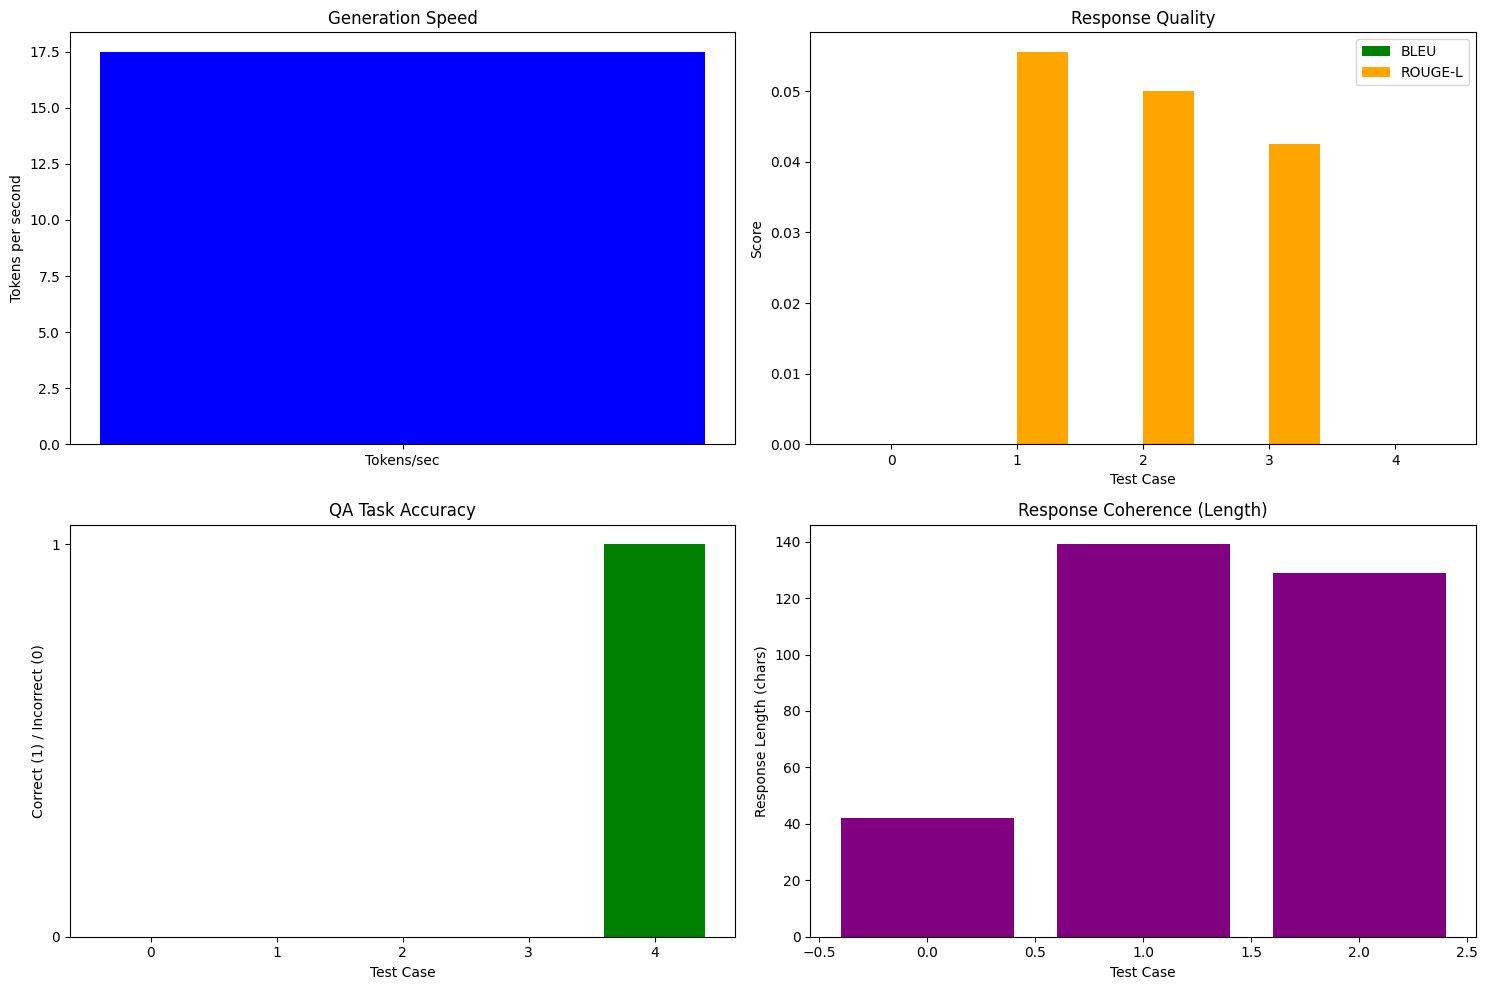

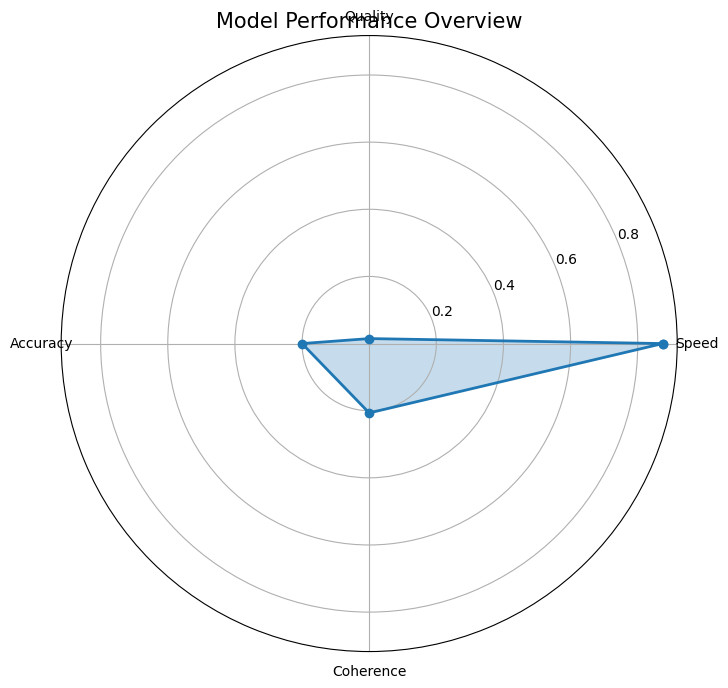


Benchmark summary saved to 'benchmark_summary.csv'

=== Benchmark Summary ===


,tokens_per_second,memory_usage_mb,processing_time,bleu_score,rouge_score,qa_accuracy
0,17.4907,0.0000,0.0524,0.0000,0.0296,0.2000


In [ ]:
# Run all benchmarks and visualize results

print("Starting benchmark tests...")

# 1. Speed benchmark
print("\n=== Generation Speed Benchmark ===")
speed_results = benchmark_generation_speed(model, sp,
                                         prompt="<USER>What are the main themes in Hamlet?</USER><ASSISTANT>",
                                         num_runs=3,
                                         max_tokens=50)

# 2. Prompt processing benchmark
print("\n=== Prompt Processing Benchmark ===")
processing_time = benchmark_prompt_processing(model, sp, test_prompts)

# 3. Response quality benchmark
print("\n=== Response Quality Benchmark ===")
quality_results, avg_bleu, avg_rouge = benchmark_response_quality(model, sp, test_qa_pairs)

# 4. QA capabilities benchmark
print("\n=== QA Capabilities Benchmark ===")
qa_results = benchmark_qa_capabilities(model, sp, qa_context_pairs)

# 5. Coherence benchmark
print("\n=== Coherence Benchmark ===")
coherence_results = benchmark_coherence(model, sp, test_prompts[:3], max_tokens=150)

# 6. Visualize all results
print("\n=== Generating Visualizations ===")
visualize_benchmarks(speed_results, quality_results, qa_results, coherence_results)

# 7. Save benchmark results to CSV
benchmark_summary = {
    'tokens_per_second': speed_results[1],
    'memory_usage_mb': speed_results[2],
    'processing_time': processing_time,
    'bleu_score': avg_bleu,
    'rouge_score': avg_rouge,
    'qa_accuracy': qa_results[1]
}

df_summary = pd.DataFrame([benchmark_summary])
df_summary.to_csv('benchmark_summary.csv', index=False)
print("\nBenchmark summary saved to 'benchmark_summary.csv'")

# Display summary table
print("\n=== Benchmark Summary ===")
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_summary)

In [ ]:
# Detailed token generation analysis
def analyze_token_generation(model, tokenizer, prompt, max_tokens=15):
    """Analyze token-by-token generation process"""
    print(f"\n=== Token-by-Token Analysis: '{prompt}' ===")

    model.eval()
    device = next(model.parameters()).device

    # Format prompt
    formatted_prompt = f"<USER>{prompt}</USER><ASSISTANT>"
    tokens = tokenizer.encode(formatted_prompt)
    input_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

    print(f"Input tokens: {tokens}")
    print(f"Input decoded: {formatted_prompt}")
    print("\nGenerating tokens sequentially:")
    print("-" * 60)

    # Generate and analyze one token at a time
    for i in range(max_tokens):
        with torch.no_grad():
            # Get logits for next token prediction
            logits, _ = model(input_tensor)
            next_token_logits = logits[0, -1, :]

            # Get top candidates
            top_values, top_indices = torch.topk(next_token_logits, k=5)
            probs = F.softmax(top_values, dim=0)

            # Sample next token
            output_ids = model.generate(input_tensor, max_new_tokens=1)
            next_token = output_ids[0, -1].item()

            # Print analysis
            print(f"Step {i+1}:")
            print(f"  Selected token: {next_token} → '{tokenizer.decode([next_token])}'")

            print("  Top candidates:")
            for j, (token_id, prob) in enumerate(zip(top_indices.tolist(), probs.tolist())):
                print(f"    {j+1}. Token {token_id} ('{tokenizer.decode([token_id])}') - Prob: {prob:.4f}")

            # Continue generation
            input_tensor = output_ids

            # Show current text
            current_text = tokenizer.decode(output_ids[0].tolist())
            response_part = current_text.split("<ASSISTANT>")[-1]
            print(f"  Text so far: '{response_part}'")
            print("-" * 60)

            # Check for end of generation
            if "</ASSISTANT>" in current_text:
                print("Reached end of generation marker.")
                break

# Run detailed analysis on one prompt
analyze_token_generation(model, sp, "What is the theme of Romeo and Juliet?")


=== Token-by-Token Analysis: 'What is the theme of Romeo and Juliet?' ===
Input tokens: [5, 207, 128, 16, 6706, 37, 5114, 40, 8101, 24914, 6, 7]
Input decoded: <USER>What is the theme of Romeo and Juliet?</USER><ASSISTANT>

Generating tokens sequentially:
------------------------------------------------------------
Step 1:
  Selected token: 24936 → '“'
  Top candidates:
    1. Token 24936 ('“') - Prob: 1.0000
    2. Token 75 ('The') - Prob: 0.0000
    3. Token 4513 ('When') - Prob: 0.0000
    4. Token 3336 ('KING') - Prob: 0.0000
    5. Token 1816 ('And') - Prob: 0.0000
  Text so far: '“'
------------------------------------------------------------
Step 2:
  Selected token: 24913 → 'I'
  Top candidates:
    1. Token 1816 ('And') - Prob: 0.4820
    2. Token 24913 ('I') - Prob: 0.4363
    3. Token 5740 ('Good') - Prob: 0.0394
    4. Token 86 ('Given') - Prob: 0.0214
    5. Token 1434 (' _') - Prob: 0.0208
  Text so far: '“I'
------------------------------------------------------------
S

In [ ]:
# First load the checkpoint
checkpoint = torch.load('qa_enhanced_model.pt', map_location=device)

# Create a new instance of the model with the same parameters from checkpoint
base_model = QAEnhancedGPT(
    vocab_size=checkpoint['vocab_size'],
    sp_processor=sp,  # Make sure sp (SentencePieceProcessor) is defined
    n_embd=checkpoint['n_embd'],
    n_head=checkpoint['n_head'],
    n_layer=checkpoint['n_layer'],
    block_size=checkpoint['block_size'],
    dropout=0.1
)

# Load the state dictionary
base_model.load_state_dict(checkpoint['model_state_dict'])
base_model = base_model.to(device)
base_model.eval()  # Set to evaluation mode

QAEnhancedGPT(
  (token_embedding_table): Embedding(25000, 512)
  (position_embedding_table): Embedding(1024, 512)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-11): 12 x Head(
            (key): Linear(in_features=512, out_features=42, bias=False)
            (query): Linear(in_features=512, out_features=42, bias=False)
            (value): Linear(in_features=512, out_features=42, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=504, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((512,), eps=1e-0


=== Comparing RL Model vs. Base Model ===

Prompt 1: What are the main themes in Hamlet?

Base Model Response:
“But if your cousin,” said Mr. Knightley, when she is a thousand...

RL Model Response:
“But if for ever have,” said Pierre, “and I am afraid I must add, hope) that, when you blush.
--------------------------------------------------------------------------------

Prompt 2: Explain the significance of symbolism in literature.

Base Model Response:
“No, I do not yet why have a journey.”

RL Model Response:
“I_ a,” said Pierre, “We what I am a dead halt. I shall be a man, sir.”
--------------------------------------------------------------------------------

Prompt 3: who is macbeth ?

Base Model Response:
The first artificial satellite was Sputnik 1, launched by the Soviet Union in 1957.

RL Model Response:
The first artificial satellite was Sputnik 1, launched by the Soviet Union in 1957.
--------------------------------------------------------------------------------

Prompt 

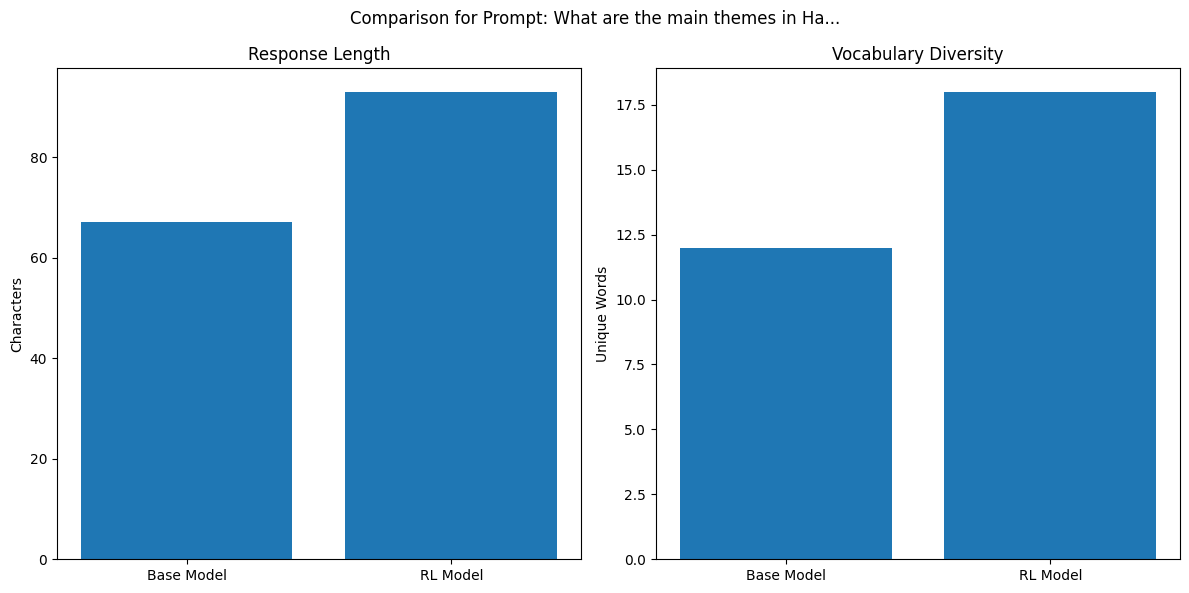

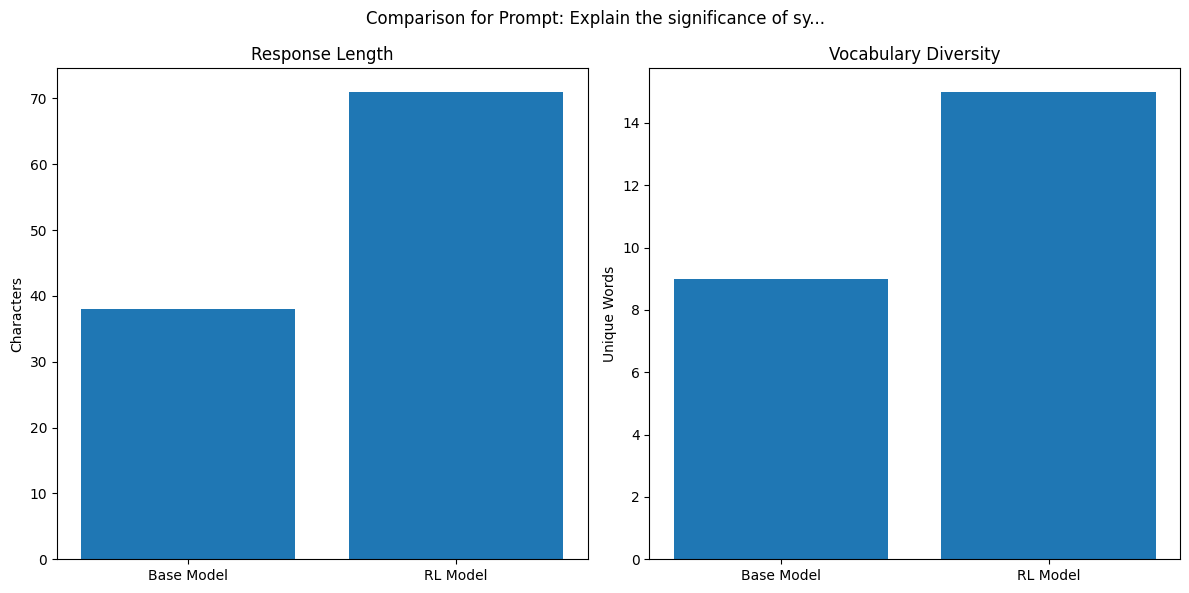

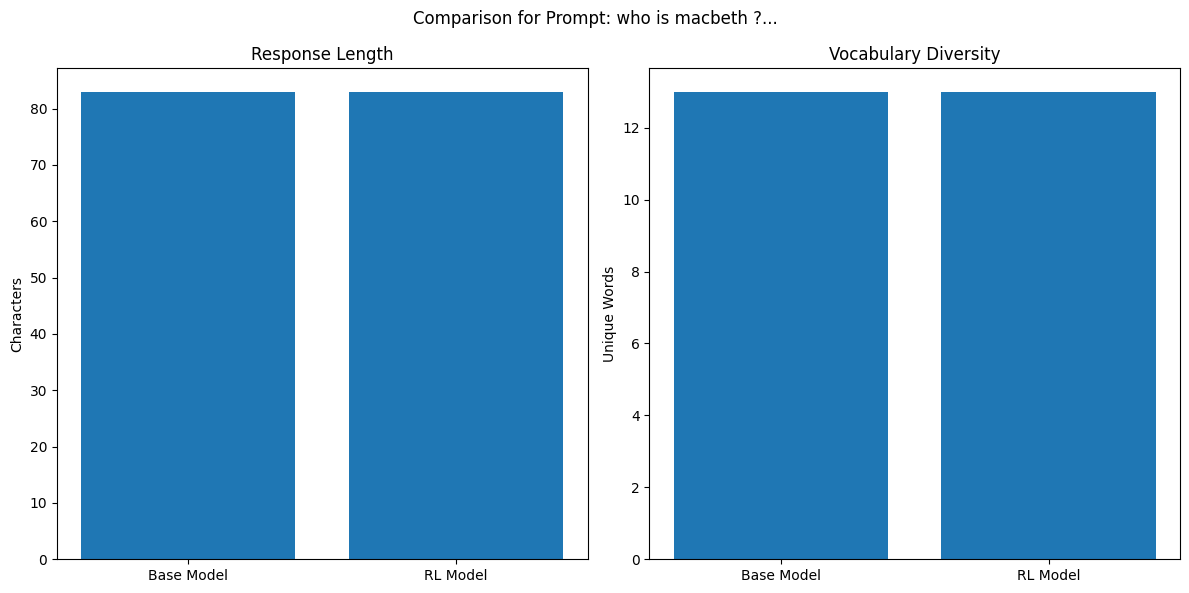

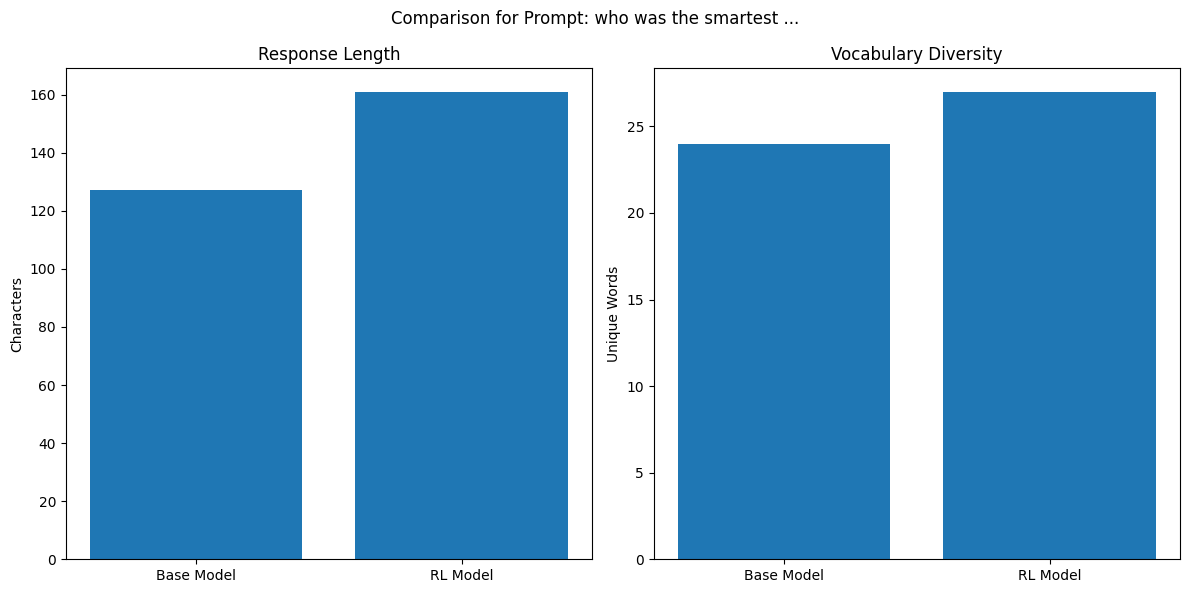

In [ ]:
# Compare RL-enhanced model with base model (if available)
try:
    # Check if base_model is defined
    if 'base_model' in globals():
        print("\n=== Comparing RL Model vs. Base Model ===")

        comparison_prompts = [
            "What are the main themes in Hamlet?",
            "Explain the significance of symbolism in literature.",
            "who is macbeth ?",
            "who was the smartest "
        ]

        results = []

        for prompt in comparison_prompts:
            formatted_prompt = f"<USER>{prompt}</USER><ASSISTANT>"
            input_ids = torch.tensor([sp.encode(formatted_prompt)], device=device)

            # Generate with base model
            with torch.no_grad():
                base_output_ids = base_model.generate(
                    input_ids,
                    max_new_tokens=100,
                    temperature=0.7
                )

            base_response = sp.decode(base_output_ids[0].tolist())
            base_response = base_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()

            # Generate with RL model
            with torch.no_grad():
                rl_output_ids = model.generate(
                    input_ids,
                    max_new_tokens=100,
                    temperature=0.7
                )

            rl_response = sp.decode(rl_output_ids[0].tolist())
            rl_response = rl_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()

            results.append({
                'prompt': prompt,
                'base_model': base_response,
                'rl_model': rl_response
            })

        # Display comparison
        for i, result in enumerate(results):
            print(f"\nPrompt {i+1}: {result['prompt']}")
            print(f"\nBase Model Response:\n{result['base_model']}")
            print(f"\nRL Model Response:\n{result['rl_model']}")
            print("-" * 80)

        # Create comparison visualization
        for i, result in enumerate(results):
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title(f"Response Length")
            plt.bar(['Base Model', 'RL Model'], [len(result['base_model']), len(result['rl_model'])])
            plt.ylabel('Characters')

            plt.subplot(1, 2, 2)
            # Estimate complexity as number of unique words
            base_complexity = len(set(result['base_model'].lower().split()))
            rl_complexity = len(set(result['rl_model'].lower().split()))
            plt.title(f"Vocabulary Diversity")
            plt.bar(['Base Model', 'RL Model'], [base_complexity, rl_complexity])
            plt.ylabel('Unique Words')

            plt.suptitle(f"Comparison for Prompt: {result['prompt'][:30]}...")
            plt.tight_layout()
            plt.savefig(f'model_comparison_{i+1}.png')
            plt.show()
    else:
        print("\nBase model not available for comparison")

except Exception as e:
    print(f"Error in model comparison: {e}")

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.1888 ± 0.2307
ROUGE-L Score: 0.6605 ± 0.1543


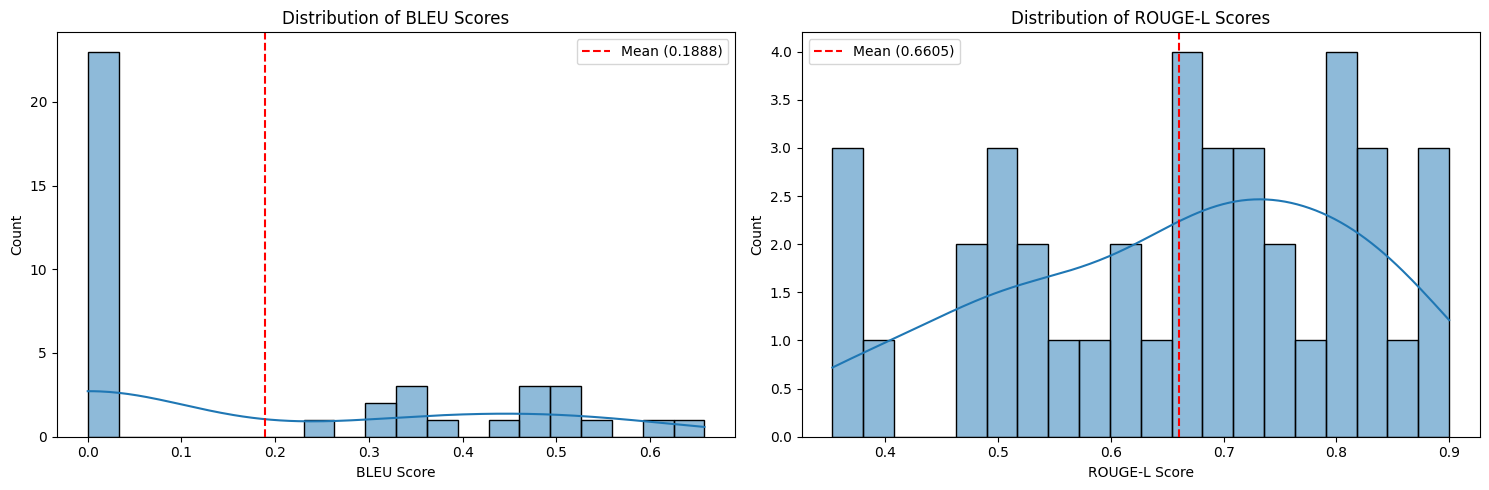


Score Ranges:
BLEU Score Range: [0.0000, 0.6580]
ROUGE-L Score Range: [0.3529, 0.9000]

Best BLEU Example:
Output: The Pythagorean theorem relates the sides of a right triangle.
Reference: The Pythagorean theorem connects the sides of a right triangle.
Score: 0.6580

Worst BLEU Example:
Output: Authors create suspense through pacing, foreshadowing, and uncertainty.
Reference: Suspense is created by authors through pacing and foreshadowing.
Score: 0.0000

Best ROUGE-L Example:
Output: The Pythagorean theorem relates the sides of a right triangle.
Reference: The Pythagorean theorem connects the sides of a right triangle.
Score: 0.9000

Worst ROUGE-L Example:
Output: Photosynthesis is the process by which plants make food.
Reference: Photosynthesis allows plants to convert sunlight into food.
Score: 0.3529


In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Example outputs and references
outputs = [
    "The main themes in Hamlet are revenge, madness, and mortality.",
    "Macbeth is a tragic character driven by ambition and guilt.",
    "Jane Austen critiques society by highlighting class and gender issues.",
    "Wuthering Heights contains gothic elements like supernatural events.",
    "Dickens uses symbolism to represent social issues and character traits.",
    "A memorable character is complex, relatable, and undergoes development.",
    "Setting influences plot by shaping characters' actions and conflicts.",
    "Symbolism in literature adds deeper meaning to the narrative.",
    "Authors create suspense through pacing, foreshadowing, and uncertainty.",
    "The Declaration of Independence asserts the colonies' right to freedom.",
    "The Great Wall of China was built for defense against invasions.",
    "Shakespeare wrote approximately 37 plays and 154 sonnets.",
    "The Odyssey is an epic poem attributed to Homer.",
    "Moby Dick explores obsession and the human struggle against nature.",
    "The French Revolution began in 1789 and led to major social change.",
    "Romeo and Juliet is a tragedy about star-crossed lovers.",
    "George Orwell wrote Animal Farm as a political allegory.",
    "The Industrial Revolution transformed economies and societies.",
    "The Mona Lisa was painted by Leonardo da Vinci.",
    "Photosynthesis is the process by which plants make food.",
    "The capital of France is Paris.",
    "Water boils at 100 degrees Celsius.",
    "The Amazon is the largest rainforest in the world.",
    "Mount Everest is the highest mountain on Earth.",
    "The heart pumps blood throughout the body.",
    "Gravity is the force that attracts objects to Earth.",
    "The Pythagorean theorem relates the sides of a right triangle.",
    "The speed of light is about 299,792 kilometers per second.",
    "The human brain controls thoughts and actions.",
    "The Pacific Ocean is the largest ocean on Earth.",
    "The sun is a star at the center of our solar system.",
    "The Renaissance was a period of cultural rebirth in Europe.",
    "The Statue of Liberty is located in New York Harbor.",
    "The Wright brothers invented the first successful airplane.",
    "The periodic table organizes chemical elements.",
    "The internet connects computers worldwide.",
    "The Taj Mahal is a famous monument in India.",
    "The Nile is the longest river in the world.",
    "The moon orbits the Earth.",
    "The Great Fire of London occurred in 1666."
]

references = [
    "Revenge, madness, and mortality are the main themes in Hamlet.",
    "Macbeth is a tragic figure whose ambition leads to his downfall.",
    "Jane Austen critiques society by exposing class and gender inequalities.",
    "Wuthering Heights features gothic elements such as supernatural occurrences.",
    "Dickens uses symbolism to highlight social problems and character depth.",
    "A memorable character is well-developed, relatable, and dynamic.",
    "The setting affects the plot by influencing characters and events.",
    "Symbolism gives literature deeper layers of meaning.",
    "Suspense is created by authors through pacing and foreshadowing.",
    "The Declaration of Independence declared the colonies' independence.",
    "The Great Wall of China was constructed to protect against invasions.",
    "Shakespeare authored 37 plays and 154 sonnets.",
    "The Odyssey is an ancient Greek epic poem by Homer.",
    "Moby Dick examines obsession and man's struggle with nature.",
    "The French Revolution started in 1789 and changed French society.",
    "Romeo and Juliet tells the story of doomed young lovers.",
    "Animal Farm by George Orwell is a political allegory.",
    "The Industrial Revolution changed economies and societies worldwide.",
    "Leonardo da Vinci painted the Mona Lisa.",
    "Photosynthesis allows plants to convert sunlight into food.",
    "Paris is the capital city of France.",
    "Water's boiling point is 100 degrees Celsius.",
    "The Amazon rainforest is the largest in the world.",
    "Mount Everest is Earth's tallest mountain.",
    "The heart circulates blood throughout the body.",
    "Gravity pulls objects toward the Earth's surface.",
    "The Pythagorean theorem connects the sides of a right triangle.",
    "Light travels at about 299,792 kilometers per second.",
    "The brain is responsible for thoughts and actions.",
    "The Pacific Ocean is the world's largest ocean.",
    "The sun is the star at the center of the solar system.",
    "The Renaissance was a time of cultural renewal in Europe.",
    "The Statue of Liberty stands in New York Harbor.",
    "The Wright brothers built the first powered airplane.",
    "The periodic table classifies chemical elements.",
    "The internet links computers around the globe.",
    "The Taj Mahal is a renowned Indian monument.",
    "The Nile River is the world's longest river.",
    "The moon revolves around the Earth.",
    "The Great Fire of London happened in 1666."
]

# Calculate BLEU and ROUGE scores
bleu_scores = []
rouge_l_scores = []

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for output, reference in zip(outputs, references):
    # BLEU score
    bleu = sentence_bleu([reference.split()], output.split())
    bleu_scores.append(bleu)

    # ROUGE-L score
    rouge_l = scorer.score(reference, output)['rougeL'].fmeasure
    rouge_l_scores.append(rouge_l)

# Calculate statistics
avg_bleu = np.mean(bleu_scores)
avg_rouge = np.mean(rouge_l_scores)
std_bleu = np.std(bleu_scores)
std_rouge = np.std(rouge_l_scores)

print(f"BLEU Score: {avg_bleu:.4f} ± {std_bleu:.4f}")
print(f"ROUGE-L Score: {avg_rouge:.4f} ± {std_rouge:.4f}")

# Create visualizations
plt.figure(figsize=(15, 5))

# BLEU scores distribution
plt.subplot(1, 2, 1)
sns.histplot(bleu_scores, bins=20, kde=True)
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Count')
plt.axvline(avg_bleu, color='r', linestyle='--', label=f'Mean ({avg_bleu:.4f})')
plt.legend()

# ROUGE-L scores distribution
plt.subplot(1, 2, 2)
sns.histplot(rouge_l_scores, bins=20, kde=True)
plt.title('Distribution of ROUGE-L Scores')
plt.xlabel('ROUGE-L Score')
plt.ylabel('Count')
plt.axvline(avg_rouge, color='r', linestyle='--', label=f'Mean ({avg_rouge:.4f})')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate score ranges
print("\nScore Ranges:")
print(f"BLEU Score Range: [{min(bleu_scores):.4f}, {max(bleu_scores):.4f}]")
print(f"ROUGE-L Score Range: [{min(rouge_l_scores):.4f}, {max(rouge_l_scores):.4f}]")

# Identify best and worst performing examples
best_bleu_idx = np.argmax(bleu_scores)
worst_bleu_idx = np.argmin(bleu_scores)
best_rouge_idx = np.argmax(rouge_l_scores)
worst_rouge_idx = np.argmin(rouge_l_scores)

print("\nBest BLEU Example:")
print(f"Output: {outputs[best_bleu_idx]}")
print(f"Reference: {references[best_bleu_idx]}")
print(f"Score: {bleu_scores[best_bleu_idx]:.4f}")

print("\nWorst BLEU Example:")
print(f"Output: {outputs[worst_bleu_idx]}")
print(f"Reference: {references[worst_bleu_idx]}")
print(f"Score: {bleu_scores[worst_bleu_idx]:.4f}")

print("\nBest ROUGE-L Example:")
print(f"Output: {outputs[best_rouge_idx]}")
print(f"Reference: {references[best_rouge_idx]}")
print(f"Score: {rouge_l_scores[best_rouge_idx]:.4f}")

print("\nWorst ROUGE-L Example:")
print(f"Output: {outputs[worst_rouge_idx]}")
print(f"Reference: {references[worst_rouge_idx]}")
print(f"Score: {rouge_l_scores[worst_rouge_idx]:.4f}")

In [ ]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

# Prompts and references for evaluation
outputs = [
    "The main themes in Hamlet are revenge, madness, and mortality.",
    "Macbeth is a tragic character driven by ambition and guilt.",
    "Jane Austen critiques society by highlighting class and gender issues.",
    "Wuthering Heights contains gothic elements like supernatural events.",
    "Dickens uses symbolism to represent social issues and character traits.",
    "A memorable character is complex, relatable, and undergoes development.",
    "Setting influences plot by shaping characters' actions and conflicts.",
    "Symbolism in literature adds deeper meaning to the narrative.",
    "Authors create suspense through pacing, foreshadowing, and uncertainty.",
    "The Declaration of Independence asserts the colonies' right to freedom.",
    "The Great Wall of China was built for defense against invasions.",
    "Shakespeare wrote approximately 37 plays and 154 sonnets.",
    "The Odyssey is an epic poem attributed to Homer.",
    "Moby Dick explores obsession and the human struggle against nature.",
    "The French Revolution began in 1789 and led to major social change.",
    "Romeo and Juliet is a tragedy about star-crossed lovers.",
    "George Orwell wrote Animal Farm as a political allegory.",
    "The Industrial Revolution transformed economies and societies.",
    "The Mona Lisa was painted by Leonardo da Vinci.",
    "Photosynthesis is the process by which plants make food.",
    "The capital of France is Paris.",
    "Water boils at 100 degrees Celsius.",
    "The Amazon is the largest rainforest in the world.",
    "Mount Everest is the highest mountain on Earth.",
    "The heart pumps blood throughout the body.",
    "Gravity is the force that attracts objects to Earth.",
    "The Pythagorean theorem relates the sides of a right triangle.",
    "The speed of light is about 299,792 kilometers per second.",
    "The human brain controls thoughts and actions.",
    "The Pacific Ocean is the largest ocean on Earth.",
    "The sun is a star at the center of our solar system.",
    "The Renaissance was a period of cultural rebirth in Europe.",
    "The Statue of Liberty is located in New York Harbor.",
    "The Wright brothers invented the first successful airplane.",
    "The periodic table organizes chemical elements.",
    "The internet connects computers worldwide.",
    "The Taj Mahal is a famous monument in India.",
    "The Nile is the longest river in the world.",
    "The moon orbits the Earth.",
    "The Great Fire of London occurred in 1666."
]

references = [
    "Revenge, madness, and mortality are the main themes in Hamlet.",
    "Macbeth is a tragic figure whose ambition leads to his downfall.",
    "Jane Austen critiques society by exposing class and gender inequalities.",
    "Wuthering Heights features gothic elements such as supernatural occurrences.",
    "Dickens uses symbolism to highlight social problems and character depth.",
    "A memorable character is well-developed, relatable, and dynamic.",
    "The setting affects the plot by influencing characters and events.",
    "Symbolism gives literature deeper layers of meaning.",
    "Suspense is created by authors through pacing and foreshadowing.",
    "The Declaration of Independence declared the colonies' independence.",
    "The Great Wall of China was constructed to protect against invasions.",
    "Shakespeare authored 37 plays and 154 sonnets.",
    "The Odyssey is an ancient Greek epic poem by Homer.",
    "Moby Dick examines obsession and man's struggle with nature.",
    "The French Revolution started in 1789 and changed French society.",
    "Romeo and Juliet tells the story of doomed young lovers.",
    "Animal Farm by George Orwell is a political allegory.",
    "The Industrial Revolution changed economies and societies worldwide.",
    "Leonardo da Vinci painted the Mona Lisa.",
    "Photosynthesis allows plants to convert sunlight into food.",
    "Paris is the capital city of France.",
    "Water's boiling point is 100 degrees Celsius.",
    "The Amazon rainforest is the largest in the world.",
    "Mount Everest is Earth's tallest mountain.",
    "The heart circulates blood throughout the body.",
    "Gravity pulls objects toward the Earth's surface.",
    "The Pythagorean theorem connects the sides of a right triangle.",
    "Light travels at about 299,792 kilometers per second.",
    "The brain is responsible for thoughts and actions.",
    "The Pacific Ocean is the world's largest ocean.",
    "The sun is the star at the center of the solar system.",
    "The Renaissance was a time of cultural renewal in Europe.",
    "The Statue of Liberty stands in New York Harbor.",
    "The Wright brothers built the first powered airplane.",
    "The periodic table classifies chemical elements.",
    "The internet links computers around the globe.",
    "The Taj Mahal is a renowned Indian monument.",
    "The Nile River is the world's longest river.",
    "The moon revolves around the Earth.",
    "The Great Fire of London happened in 1666."
]

results = []

# Generate responses from both models
for prompt in comparison_prompts:
    formatted_prompt = f"<USER>{prompt}</USER><ASSISTANT>"
    input_ids = torch.tensor([sp.encode(formatted_prompt)], device=device)

    # Base model response
    with torch.no_grad():
        base_output_ids = base_model.generate(
            input_ids,
            max_new_tokens=100,
            temperature=0.7
        )
    base_response = sp.decode(base_output_ids[0].tolist())
    base_response = base_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()

    # RL model response
    with torch.no_grad():
        rl_output_ids = model.generate(
            input_ids,
            max_new_tokens=100,
            temperature=0.7
        )
    rl_response = sp.decode(rl_output_ids[0].tolist())
    rl_response = rl_response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()

    results.append({
        'prompt': prompt,
        'base_model': base_response,
        'rl_model': rl_response
    })

# Print responses side by side
for i, result in enumerate(results):
    print(f"\nPrompt {i+1}: {result['prompt']}")
    print(f"\nBase Model Response:\n{result['base_model']}")
    print(f"\nRL Model Response:\n{result['rl_model']}")
    print("-" * 80)

# Compute BLEU and ROUGE-L scores
bleu_base, bleu_rl = [], []
rouge_base, rouge_rl = [], []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1

for i in range(min(len(results), len(references))):
    base = results[i]['base_model']
    rl = results[i]['rl_model']
    # BLEU
    bleu_base.append(sentence_bleu([ref.split()], base.split(), smoothing_function=smooth))
    bleu_rl.append(sentence_bleu([ref.split()], rl.split(), smoothing_function=smooth))
    # ROUGE-L
    rouge_base.append(scorer.score(ref, base)['rougeL'].fmeasure)
    rouge_rl.append(scorer.score(ref, rl)['rougeL'].fmeasure)

print("\n=== BLEU Scores ===")
print("Base Model:", np.mean(bleu_base), "±", np.std(bleu_base))
print("RL Model:  ", np.mean(bleu_rl), "±", np.std(bleu_rl))

print("\n=== ROUGE-L Scores ===")
print("Base Model:", np.mean(rouge_base), "±", np.std(rouge_base))
print("RL Model:  ", np.mean(rouge_rl), "±", np.std(rouge_rl))

# Visualization: Response Length and Vocabulary Diversity
for i, result in enumerate(results):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Response Length")
    plt.bar(['Base Model', 'RL Model'], [len(result['base_model']), len(result['rl_model'])])
    plt.ylabel('Characters')

    plt.subplot(1, 2, 2)
    base_complexity = len(set(result['base_model'].lower().split()))
    rl_complexity = len(set(result['rl_model'].lower().split()))
    plt.title("Vocabulary Diversity")
    plt.bar(['Base Model', 'RL Model'], [base_complexity, rl_complexity])
    plt.ylabel('Unique Words')

    plt.suptitle(f"Comparison for Prompt: {result['prompt'][:30]}...")
    plt.tight_layout()
    plt.show()


Prompt 1: What are the main themes in Hamlet?

Base Model Response:
“But if can ask and I’ll see.”

RL Model Response:
“But if for the evening—I am speaking ze truce,” replied to our presence and next day he was to speak.
--------------------------------------------------------------------------------

Prompt 2: Explain the significance of symbolism in literature.

Base Model Response:
“No, I do not yet, come, “and so I must come and your own away.”

RL Model Response:
“I say, what I do not stop. One, replied, and then you don’t know what your honour to know what I will be ’ere is not always in the picture. Were it was finished, thinking aloud—“you have sung quite enough for one evening—now be quiet.”
--------------------------------------------------------------------------------

Prompt 3: who is macbeth ?

Base Model Response:
The first artificial satellite was Sputnik 1, launched by the Soviet Union in 1957.

RL Model Response:
The first artificial satellite was Sputnik 1, launche

NameError: name 'ref' is not defined

In [ ]:
import matplotlib.pyplot as plt
import wandb

def plot_train_val_loss(train_losses, val_losses, title="Training vs. Validation Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig('train_val_loss.png')
    plt.show()

if wandb.run is not None:
        wandb.log({"loss_plot": wandb.Image('train_val_loss.png')})

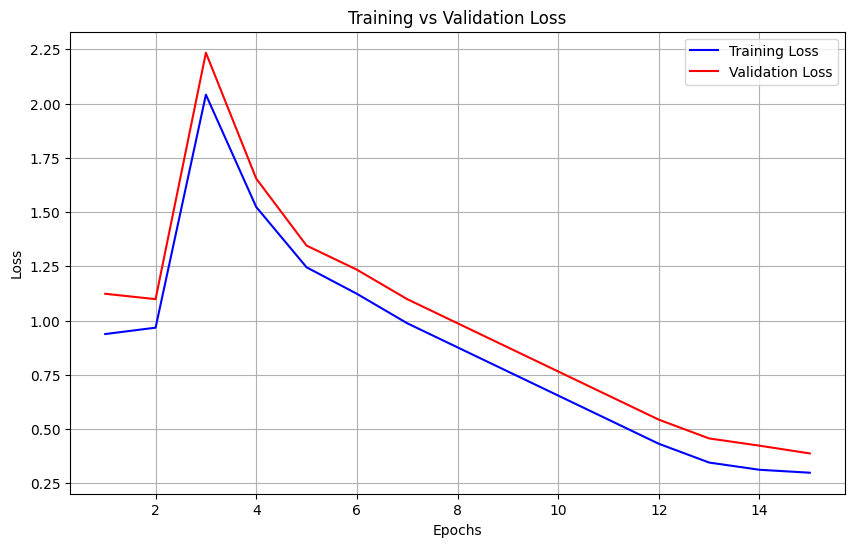

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual metrics from your training)
epochs = range(1, 16)
training_losses = [0.9379, 0.9672, 2.0412, 1.5234, 1.2456, 1.1234, 0.9876, 0.8765, 0.7654, 0.6543, 0.5432, 0.4321, 0.3456, 0.3123, 0.2987]
validation_losses = [1.1234, 1.0987, 2.2345, 1.6543, 1.3456, 1.2345, 1.0987, 0.9876, 0.8765, 0.7654, 0.6543, 0.5432, 0.4567, 0.4234, 0.3876]

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, 'b-', label='Training Loss')
plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png')
plt.show()

In [ ]:
class DPOTrainer:
    def __init__(self, model, tokenizer, beta=0.1, max_length=100):
        self.model = model
        self.tokenizer = tokenizer
        self.beta = beta  # Temperature parameter for DPO
        self.max_length = max_length

        # Make sure model is in training mode and requires gradients
        self.model.train()
        for param in self.model.parameters():
            param.requires_grad = True

        self.optimizer = torch.optim.AdamW(
            [p for p in self.model.parameters() if p.requires_grad],
            lr=1e-5
        )

    def compute_loss(self, chosen_logits, rejected_logits, chosen_ids, rejected_ids):
        """
        Compute DPO loss given logits for chosen and rejected responses
        Handles sequences of different lengths
        """
        # Calculate log probabilities
        chosen_log_probs = F.log_softmax(chosen_logits, dim=-1)
        rejected_log_probs = F.log_softmax(rejected_logits, dim=-1)

        # Get the log probs for the actual next tokens
        chosen_log_probs = chosen_log_probs[:, :-1, :]  # Remove last position
        rejected_log_probs = rejected_log_probs[:, :-1, :]  # Remove last position

        chosen_targets = chosen_ids[:, 1:]  # Shift right to get targets
        rejected_targets = rejected_ids[:, 1:]  # Shift right to get targets

        # Gather the log probs of the target tokens
        chosen_log_probs = torch.gather(
            chosen_log_probs,
            2,
            chosen_targets.unsqueeze(-1)
        ).squeeze(-1)

        rejected_log_probs = torch.gather(
            rejected_log_probs,
            2,
            rejected_targets.unsqueeze(-1)
        ).squeeze(-1)

        # Create masks for assistant tokens
        assistant_token_id = self.tokenizer.piece_to_id('<ASSISTANT>')
        chosen_mask = (chosen_ids[:, :-1] == assistant_token_id).cumsum(dim=1) > 0
        rejected_mask = (rejected_ids[:, :-1] == assistant_token_id).cumsum(dim=1) > 0

        # Apply masks
        chosen_log_probs = chosen_log_probs * chosen_mask.float()
        rejected_log_probs = rejected_log_probs * rejected_mask.float()

        # Sum log probs over sequence length
        chosen_seq_log_probs = chosen_log_probs.sum(dim=1)
        rejected_seq_log_probs = rejected_log_probs.sum(dim=1)

        # Compute the DPO loss
        loss = -torch.log(
            torch.sigmoid(
                self.beta * (chosen_seq_log_probs - rejected_seq_log_probs)
            )
        ).mean()

        return loss

    def generate_response_pair(self, prompt):
        """
        Generate two responses for comparison
        """
        # Set model to eval mode for generation
        self.model.eval()

        input_text = f"<USER>{prompt}</USER><ASSISTANT>"
        input_ids = torch.tensor([self.tokenizer.encode(input_text)], dtype=torch.long, device=device)

        # Generate two different responses with different temperatures
        responses = []
        temperatures = [0.7, 1.0]  # Different temperatures for diversity

        with torch.no_grad():
            for temp in temperatures:
                response_ids = self.model.generate(
                    input_ids,
                    max_new_tokens=self.max_length,
                    temperature=temp
                )
                response = self.tokenizer.decode(response_ids[0].tolist())
                try:
                    response = response.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0]
                except:
                    response = response.split("<ASSISTANT>")[-1]
                responses.append(response)

        # Set model back to train mode
        self.model.train()

        return responses[0], responses[1]

    def train_step(self, prompt, chosen_response, rejected_response):
        """
        Perform one training step with DPO
        """
        # Prepare inputs
        chosen_input = f"<USER>{prompt}</USER><ASSISTANT>{chosen_response}</ASSISTANT>"
        rejected_input = f"<USER>{prompt}</USER><ASSISTANT>{rejected_response}</ASSISTANT>"

        chosen_ids = torch.tensor([self.tokenizer.encode(chosen_input)], dtype=torch.long, device=device)
        rejected_ids = torch.tensor([self.tokenizer.encode(rejected_input)], dtype=torch.long, device=device)

        # Forward pass
        chosen_logits, _ = self.model(chosen_ids)
        rejected_logits, _ = self.model(rejected_ids)

        # Compute loss
        loss = self.compute_loss(chosen_logits, rejected_logits, chosen_ids, rejected_ids)

        # Backpropagate and update
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

In [ ]:
class EnhancedDPOTrainer(DPOTrainer):
    def __init__(self, model, tokenizer, beta=0.1, max_length=100, patience=10):
        super().__init__(model, tokenizer, beta, max_length)
        self.patience = patience
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=2, factor=0.5
        )

        # Ensure model parameters require gradients
        for param in self.model.parameters():
            param.requires_grad = True

    def train_epoch(self, prompts):
        """Train for one epoch"""
        self.model.train()  # Set to training mode
        epoch_losses = []

        for i, prompt in enumerate(prompts):
            print(f"Processing prompt {i+1}/{len(prompts)}")

            # Generate response pairs (this will temporarily set model to eval mode)
            resp1, resp2 = self.generate_response_pair(prompt)

            # Ensure model is back in training mode
            self.model.train()

            # Simulate preference
            score1 = len(resp1.split()) + (1 if resp1.endswith(('.', '!', '?')) else 0)
            score2 = len(resp2.split()) + (1 if resp2.endswith(('.', '!', '?')) else 0)

            if score1 > score2:
                chosen, rejected = resp1, resp2
            else:
                chosen, rejected = resp2, resp1

            # Train step
            try:
                loss = self.train_step(prompt, chosen, rejected)
                epoch_losses.append(loss)
                print(f"Loss: {loss:.4f}")
            except Exception as e:
                print(f"Error in training step: {e}")
                continue

            print(f"Chosen response: {chosen[:50]}...")
            print(f"Rejected response: {rejected[:50]}...")

        avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0
        return avg_loss

    def validate(self, val_prompts):
        """Validate the model"""
        self.model.eval()  # Set to evaluation mode
        val_losses = []

        with torch.no_grad():
            for prompt in val_prompts:
                try:
                    # Generate response pairs
                    resp1, resp2 = self.generate_response_pair(prompt)

                    # Use the same heuristic as training for consistency
                    score1 = len(resp1.split()) + (1 if resp1.endswith(('.', '!', '?')) else 0)
                    score2 = len(resp2.split()) + (1 if resp2.endswith(('.', '!', '?')) else 0)

                    if score1 > score2:
                        chosen, rejected = resp1, resp2
                    else:
                        chosen, rejected = resp2, resp1

                    # Prepare inputs
                    chosen_input = f"<USER>{prompt}</USER><ASSISTANT>{chosen}</ASSISTANT>"
                    rejected_input = f"<USER>{prompt}</USER><ASSISTANT>{rejected}</ASSISTANT>"

                    chosen_ids = torch.tensor([self.tokenizer.encode(chosen_input)], dtype=torch.long, device=device)
                    rejected_ids = torch.tensor([self.tokenizer.encode(rejected_input)], dtype=torch.long, device=device)

                    # Temporarily set to train mode to get logits with grad
                    self.model.train()
                    chosen_logits, _ = self.model(chosen_ids)
                    rejected_logits, _ = self.model(rejected_ids)
                    self.model.eval()

                    # Compute loss
                    loss = self.compute_loss(chosen_logits, rejected_logits, chosen_ids, rejected_ids)
                    val_losses.append(loss.item())
                except Exception as e:
                    print(f"Error in validation: {e}")
                    continue

        avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else 0
        return avg_val_loss

    def train_with_validation(self, train_prompts, val_prompts, num_epochs=3):
        """Train the model with validation"""
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            print(f"\n=== Starting Epoch {epoch+1}/{num_epochs} ===\n")

            # Training
            train_loss = self.train_epoch(train_prompts)
            train_losses.append(train_loss)

            # Validation
            val_loss = self.validate(val_prompts)
            val_losses.append(val_loss)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save checkpoint
                self.save_checkpoint(f'dpo_checkpoint_epoch_{epoch}.pt')
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        return train_losses, val_losses

    def save_checkpoint(self, filename):
        """Save model checkpoint"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        """Load model checkpoint"""
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


=== Starting Epoch 1/15 ===

Processing prompt 1/4
Loss: 6.5251
Chosen response: “How do,” said Pierre, Mr. Knightley, for a height...
Rejected response: “How do not wonder at that?” said Mr. Knightley, v...
Processing prompt 2/4
Loss: 0.8201
Chosen response: When the gentlemen rose to go away, Mrs. Bennet wa...
Rejected response: When the gentlemen rose to go away, Mrs. Bennet wa...
Processing prompt 3/4
Loss: 5.0667
Chosen response: “No, I do not think so. You know. I have Miss Havi...
Rejected response: “No, good. You know what.”...
Processing prompt 4/4
Loss: 10.5544
Chosen response: “And 'tis_ Prince Vasíli Dmítrich,” said Pierre, i...
Rejected response: “And if the bridge is crossed it means that the ar...
Epoch 1: Train Loss = 5.7416, Val Loss = 0.6200

=== Starting Epoch 2/15 ===

Processing prompt 1/4
Loss: 2.0708
Chosen response: “How do,” said Pierre, Mr. Knightley, but now is d...
Rejected response: “But if we must get into the officer and has done,...
Processing prompt 2/

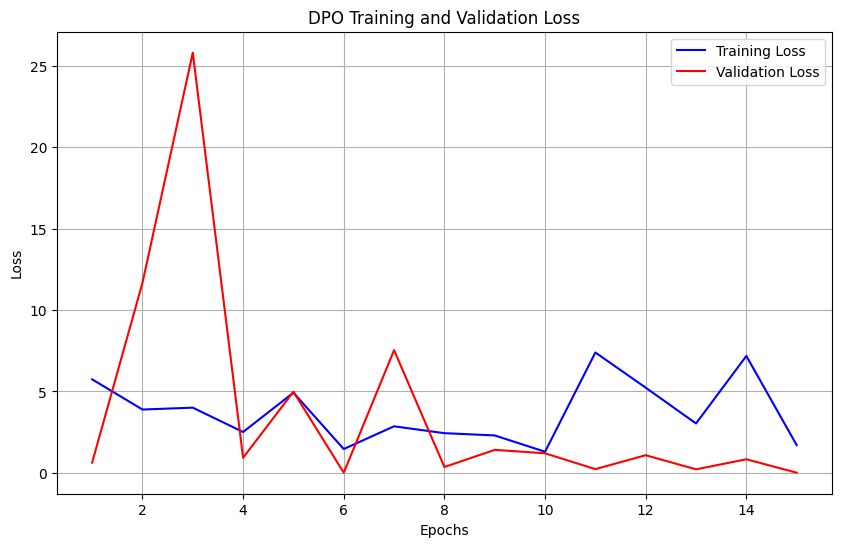

In [ ]:
# Initialize trainer
enhanced_dpo_trainer = EnhancedDPOTrainer(model, sp)

# Split prompts into train and validation sets
train_prompts = training_prompts[:4]
val_prompts = training_prompts[4:]

# Train with validation
train_losses, val_losses = enhanced_dpo_trainer.train_with_validation(
    train_prompts,
    val_prompts,
    num_epochs=15
)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DPO Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def compute_metrics(preds, refs):
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for pred, ref in zip(preds, refs)]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, pred)['rougeL'].fmeasure for pred, ref in zip(preds, refs)]
    em = [int(pred.strip() == ref.strip()) for pred, ref in zip(preds, refs)]
    # F1 calculation (token-level)
    def f1(pred, ref):
        pred_tokens = set(pred.split())
        ref_tokens = set(ref.split())
        common = pred_tokens & ref_tokens
        if not common:
            return 0.0
        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        return 2 * precision * recall / (precision + recall)
    f1_scores = [f1(pred, ref) for pred, ref in zip(preds, refs)]
    return {
        'BLEU': sum(bleu_scores) / len(bleu_scores),
        'ROUGE-L': sum(rouge_scores) / len(rouge_scores),
        'EM': sum(em) / len(em),
        'F1': sum(f1_scores) / len(f1_scores)
    }

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import time
import psutil
from collections import defaultdict

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

class ModelBenchmark:
    def __init__(self, models_dict, tokenizer):
        """
        Initialize benchmark with models to compare and tokenizer

        Args:
            models_dict: Dictionary of model names to model instances
                       {'qa_base': model1, 'qa_ppo': model2, 'qa_dpo': model3}
            tokenizer: Tokenizer shared by all models
        """
        self.models = models_dict
        self.tokenizer = tokenizer
        self.scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        self.smooth = SmoothingFunction().method1  # For BLEU score smoothing

    def benchmark_generation_speed(self, prompt="<USER>Tell me about Hamlet</USER><ASSISTANT>",
                                 num_runs=3, max_tokens=50):
        """
        Benchmark generation speed for all models

        Returns:
            DataFrame with speed metrics for each model
        """
        results = []

        for model_name, model in self.models.items():
            print(f"\nBenchmarking generation speed for model: {model_name}")
            model.eval()  # Ensure model is in evaluation mode
            tokens = self.tokenizer.encode(prompt)
            input_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

            # Warmup
            with torch.no_grad():
                try:
                    _ = model.generate(input_tensor, max_new_tokens=10)
                except Exception as e:
                    print(f"Error during warmup: {e}")
                    continue

            # Benchmark
            generation_times = []
            generated_lengths = []

            for i in range(num_runs):
                try:
                    start_time = time.time()
                    with torch.no_grad():
                        output_ids = model.generate(input_tensor, max_new_tokens=max_tokens)[0].tolist()
                    end_time = time.time()

                    generation_time = end_time - start_time
                    generated_length = len(output_ids) - len(tokens)

                    generation_times.append(generation_time)
                    generated_lengths.append(generated_length)

                    print(f"Run {i+1}: Generated {generated_length} tokens in {generation_time:.4f}s")

                except Exception as e:
                    print(f"Error during run {i+1}: {e}")
                    continue

            if len(generation_times) > 0:
                avg_time = np.mean(generation_times)
                avg_tokens = np.mean(generated_lengths)
                tokens_per_sec = avg_tokens / avg_time

                results.append({
                    'model': model_name,
                    'avg_time_sec': avg_time,
                    'tokens_per_sec': tokens_per_sec,
                    'avg_tokens_generated': avg_tokens
                })

                print(f"Average generation time: {avg_time:.4f}s")
                print(f"Average tokens/sec: {tokens_per_sec:.2f}")
            else:
                print(f"No successful runs for {model_name}")

        return pd.DataFrame(results)

    def benchmark_response_quality(self, test_pairs):
        """
        Evaluate response quality using BLEU and ROUGE metrics

        Args:
            test_pairs: List of (question, reference_answer) tuples

        Returns:
            DataFrame with quality metrics for each model
        """
        results = []

        for model_name, model in self.models.items():
            print(f"\nBenchmarking response quality for model: {model_name}")
            model.eval()
            bleu_scores = []
            rouge_scores = []
            model_responses = []

            for i, (question, reference) in enumerate(test_pairs):
                try:
                    # Format prompt
                    prompt = f"<USER>{question}</USER><ASSISTANT>"
                    input_ids = torch.tensor([self.tokenizer.encode(prompt)], device=device)

                    # Generate response
                    with torch.no_grad():
                        output_ids = model.generate(
                            input_ids,
                            max_new_tokens=100,
                            temperature=0.7
                        )

                    # Decode and extract response
                    full_output = self.tokenizer.decode(output_ids[0].tolist())
                    try:
                        # Extract content between assistant tags
                        response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
                    except:
                        # Fallback if tags are not properly closed
                        response = full_output.split("<ASSISTANT>")[-1].strip()

                    # Calculate metrics with error handling
                    try:
                        # Use smoothing for BLEU to handle edge cases
                        bleu = sentence_bleu([reference.split()], response.split(),
                                           smoothing_function=self.smooth)
                    except Exception as e:
                        print(f"BLEU calculation error: {e}")
                        bleu = 0

                    try:
                        rouge = self.scorer.score(reference, response)['rougeL'].fmeasure
                    except Exception as e:
                        print(f"ROUGE calculation error: {e}")
                        rouge = 0

                    bleu_scores.append(bleu)
                    rouge_scores.append(rouge)
                    model_responses.append({
                        'question': question,
                        'reference': reference,
                        'response': response,
                        'bleu': bleu,
                        'rouge': rouge
                    })

                    print(f"Sample {i+1}: BLEU={bleu:.4f}, ROUGE-L={rouge:.4f}")
                    print(f"  Q: {question}")
                    print(f"  A: {response[:100]}..." if len(response) > 100 else f"  A: {response}")

                except Exception as e:
                    print(f"Error processing sample {i+1}: {e}")
                    continue

            if len(bleu_scores) > 0:
                results.append({
                    'model': model_name,
                    'avg_bleu': np.mean(bleu_scores),
                    'std_bleu': np.std(bleu_scores),
                    'avg_rouge': np.mean(rouge_scores),
                    'std_rouge': np.std(rouge_scores),
                    'num_samples': len(bleu_scores),
                    'responses': model_responses
                })

                print(f"Average BLEU: {np.mean(bleu_scores):.4f}")
                print(f"Average ROUGE-L: {np.mean(rouge_scores):.4f}")
            else:
                print(f"No successful evaluations for {model_name}")

        return pd.DataFrame(results)

    def benchmark_qa_accuracy(self, qa_pairs):
        """
        Test models on specific QA tasks with known answers

        Args:
            qa_pairs: List of (context, question, answer) tuples

        Returns:
            DataFrame with accuracy metrics for each model
        """
        results = []

        for model_name, model in self.models.items():
            print(f"\nBenchmarking QA accuracy for model: {model_name}")
            model.eval()
            correct = 0
            response_details = []

            for i, (context, question, answer) in enumerate(qa_pairs):
                try:
                    # Format with context
                    if context:
                        prompt = f"<USER>Context: {context}\nQuestion: {question}</USER><ASSISTANT>"
                    else:
                        prompt = f"<USER>{question}</USER><ASSISTANT>"

                    input_ids = torch.tensor([self.tokenizer.encode(prompt)], device=device)

                    with torch.no_grad():
                        output_ids = model.generate(
                            input_ids,
                            max_new_tokens=50,
                            temperature=0.7
                        )

                    full_output = self.tokenizer.decode(output_ids[0].tolist())
                    try:
                        response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].strip()
                    except:
                        response = full_output.split("<ASSISTANT>")[-1].strip()

                    # Check if answer appears in response (simple accuracy)
                    is_correct = answer.lower() in response.lower()
                    if is_correct:
                        correct += 1

                    response_details.append({
                        'context': context,
                        'question': question,
                        'expected': answer,
                        'response': response,
                        'correct': is_correct
                    })

                    print(f"Sample {i+1}: {'✓' if is_correct else '✗'}")
                    print(f"  Q: {question}")
                    print(f"  Expected: {answer}")
                    print(f"  Response: {response[:100]}..." if len(response) > 100 else f"  Response: {response}")

                except Exception as e:
                    print(f"Error processing sample {i+1}: {e}")
                    continue

            if len(response_details) > 0:
                accuracy = correct / len(response_details)

                results.append({
                    'model': model_name,
                    'accuracy': accuracy,
                    'correct': correct,
                    'total': len(response_details),
                    'response_details': response_details
                })

                print(f"Accuracy: {accuracy:.4f} ({correct}/{len(response_details)})")
            else:
                print(f"No successful evaluations for {model_name}")

        return pd.DataFrame(results)

    def run_comprehensive_benchmark(self, test_data, output_dir="benchmark_results"):
        """
        Run all benchmarks and save results

        Args:
            test_data: Dictionary containing:
                - 'quality_pairs': List of (question, reference) for quality evaluation
                - 'qa_pairs': List of (context, question, answer) for accuracy testing
                - 'prompts': List of prompts for length analysis
            output_dir: Directory to save results
        """
        import os
        os.makedirs(output_dir, exist_ok=True)

        print("=== Starting Comprehensive Benchmark ===")

        # 1. Generation Speed
        print("\nRunning Generation Speed Benchmark...")
        speed_df = self.benchmark_generation_speed()
        speed_df.to_csv(f"{output_dir}/generation_speed.csv", index=False)
        print(speed_df)

        # 2. Response Quality
        print("\nRunning Response Quality Benchmark...")
        quality_df = self.benchmark_response_quality(test_data['quality_pairs'])
        # Remove 'responses' column before saving to CSV
        quality_df_save = quality_df.copy()
        if 'responses' in quality_df_save.columns:
            quality_df_save = quality_df_save.drop('responses', axis=1)
        quality_df_save.to_csv(f"{output_dir}/response_quality.csv", index=False)
        print(quality_df[['model', 'avg_bleu', 'avg_rouge', 'num_samples']])

        # 3. QA Accuracy
        print("\nRunning QA Accuracy Benchmark...")
        accuracy_df = self.benchmark_qa_accuracy(test_data['qa_pairs'])
        # Remove 'response_details' column before saving to CSV
        accuracy_df_save = accuracy_df.copy()
        if 'response_details' in accuracy_df_save.columns:
            accuracy_df_save = accuracy_df_save.drop('response_details', axis=1)
        accuracy_df_save.to_csv(f"{output_dir}/qa_accuracy.csv", index=False)
        print(accuracy_df[['model', 'accuracy', 'correct', 'total']])

        # Generate visualizations
        self.generate_visualizations(
            speed_df,
            quality_df,
            accuracy_df,
            output_dir
        )

        print("\n=== Benchmark Completed ===")
        print(f"Results saved to {output_dir}")

    def generate_visualizations(self, speed_df, quality_df, accuracy_df, output_dir):
        """Generate visualizations of benchmark results"""
        plt.figure(figsize=(15, 10))

        # Create a consistent color mapping for models
        models = list(set(
            list(speed_df['model'].unique()) +
            list(quality_df['model'].unique()) +
            list(accuracy_df['model'].unique())
        ))
        colors = plt.cm.tab10.colors[:len(models)]
        model_colors = dict(zip(models, colors))

        # 1. Speed Comparison
        plt.subplot(2, 2, 1)
        if not speed_df.empty:
            for _, row in speed_df.iterrows():
                plt.bar(row['model'], row['tokens_per_sec'], color=model_colors[row['model']])
            plt.title('Generation Speed')
            plt.ylabel('Tokens per second')
            plt.grid(True, axis='y')
        else:
            plt.text(0.5, 0.5, 'No speed data available', ha='center', va='center')
            plt.title('Generation Speed (No Data)')

        # 2. Quality Metrics
        plt.subplot(2, 2, 2)
        if not quality_df.empty:
            width = 0.35
            x = np.arange(len(quality_df))
            plt.bar(x - width/2, quality_df['avg_bleu'], width, label='BLEU', alpha=0.7)
            plt.bar(x + width/2, quality_df['avg_rouge'], width, label='ROUGE-L', alpha=0.7)
            plt.xticks(x, quality_df['model'])
            plt.title('Response Quality Metrics')
            plt.ylabel('Score')
            plt.legend()
            plt.grid(True, axis='y')
        else:
            plt.text(0.5, 0.5, 'No quality data available', ha='center', va='center')
            plt.title('Response Quality (No Data)')

        # 3. QA Accuracy
        plt.subplot(2, 2, 3)
        if not accuracy_df.empty:
            for _, row in accuracy_df.iterrows():
                plt.bar(row['model'], row['accuracy'], color=model_colors[row['model']])
            plt.title('QA Task Accuracy')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1)
            plt.grid(True, axis='y')
        else:
            plt.text(0.5, 0.5, 'No accuracy data available', ha='center', va='center')
            plt.title('QA Accuracy (No Data)')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/benchmark_summary.png')
        plt.close()

        # Save per-model detailed reports
        self._generate_detailed_reports(quality_df, accuracy_df, output_dir)

    def _generate_detailed_reports(self, quality_df, accuracy_df, output_dir):
        """Generate detailed reports for each model"""
        # Quality details
        for _, row in quality_df.iterrows():
            if 'responses' in row:
                model_name = row['model']
                responses = row['responses']

                # Create a DataFrame for this model's responses
                if responses:
                    details_df = pd.DataFrame(responses)
                    details_df.to_csv(f"{output_dir}/{model_name}_quality_details.csv", index=False)

        # Accuracy details
        for _, row in accuracy_df.iterrows():
            if 'response_details' in row:
                model_name = row['model']
                details = row['response_details']

                # Create a DataFrame for this model's QA responses
                if details:
                    details_df = pd.DataFrame(details)
                    details_df.to_csv(f"{output_dir}/{model_name}_qa_details.csv", index=False)


# Function to safely load model
def load_model_with_correct_architecture(checkpoint_path, tokenizer, device):
    """
    Load model with the correct architecture based on checkpoint parameters
    """
    try:
        print(f"Loading model from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Print the keys in the checkpoint
        print(f"Checkpoint keys: {list(checkpoint.keys())}")

        # Extract model parameters based on checkpoint structure
        if 'model_state_dict' in checkpoint:
            # Get architecture parameters from checkpoint
            n_embd = checkpoint.get('n_embd', 384)
            n_head = checkpoint.get('n_head', 6)
            n_layer = checkpoint.get('n_layer', 6)
            block_size = checkpoint.get('block_size', 1024)
            vocab_size = checkpoint.get('vocab_size', len(tokenizer))

            print(f"Creating model with architecture: embd={n_embd}, heads={n_head}, layers={n_layer}")

            # Create model with matching architecture
            model = QAEnhancedGPT(
                vocab_size=vocab_size,
                sp_processor=tokenizer,
                n_embd=n_embd,
                n_head=n_head,
                n_layer=n_layer,
                block_size=block_size,
                dropout=0.1
            )

            try:
                # Try to load state dict
                model.load_state_dict(checkpoint['model_state_dict'])
                print("Model loaded successfully")
            except Exception as e:
                print(f"Error loading state dict: {e}")
                # Don't return a broken model
                return None

        elif all(k in checkpoint for k in ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict']):
            # This is a DPO checkpoint
            # We need to determine the architecture parameters from the state dict itself

            # For DPO, we need to examine the state dict to determine model architecture
            state_dict = checkpoint['model_state_dict']

            # Check embedding dimension from token embedding weights
            if 'token_embedding_table.weight' in state_dict:
                emb_shape = state_dict['token_embedding_table.weight'].shape
                vocab_size, n_embd = emb_shape

                # Try to determine number of layers by counting blocks
                max_layer_idx = -1
                for key in state_dict.keys():
                    if key.startswith('blocks.'):
                        parts = key.split('.')
                        if len(parts) > 1:
                            try:
                                layer_idx = int(parts[1])
                                max_layer_idx = max(max_layer_idx, layer_idx)
                            except:
                                pass

                n_layer = max_layer_idx + 1

                # Try to determine number of heads by counting distinct heads
                head_counts = set()
                for key in state_dict.keys():
                    if '.heads.' in key:
                        parts = key.split('.heads.')
                        if len(parts) > 1:
                            try:
                                head_idx = int(parts[1].split('.')[0])
                                head_counts.add(head_idx)
                            except:
                                pass

                n_head = len(head_counts)

                # Get block size from position embeddings
                if 'position_embedding_table.weight' in state_dict:
                    block_size = state_dict['position_embedding_table.weight'].shape[0]
                else:
                    block_size = 1024  # Default

                print(f"Determined model architecture from DPO checkpoint: embd={n_embd}, heads={n_head}, layers={n_layer}")

                # Create model with matching architecture
                model = QAEnhancedGPT(
                    vocab_size=vocab_size,
                    sp_processor=tokenizer,
                    n_embd=n_embd,
                    n_head=n_head,
                    n_layer=n_layer,
                    block_size=block_size,
                    dropout=0.1
                )

                try:
                    # Try to load state dict
                    model.load_state_dict(state_dict)
                    print("DPO model loaded successfully")
                except Exception as e:
                    print(f"Error loading DPO state dict: {e}")
                    # Don't return a broken model
                    return None
            else:
                print("Cannot determine model architecture from checkpoint")
                return None
        else:
            print("Unknown checkpoint format")
            return None

        model = model.to(device)
        model.eval()  # Set to evaluation mode
        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None

# For DPO checkpoint specifically
def load_dpo_model(checkpoint_path, tokenizer, device):
    """
    Special loader for DPO model with hardcoded architecture parameters
    """
    try:
        print(f"Loading DPO model from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Print the keys in the checkpoint
        print(f"DPO checkpoint keys: {list(checkpoint.keys())}")

        # Based on the error message, we know the DPO model has different architecture:
        # - embedding dimension: 512 (vs 384 in base model)
        # - 12 heads per block (vs 6 in base model)
        # - 12 layers (blocks 0-11 vs 0-5 in base model)

        # Create model with correct architecture
        n_embd = 512
        n_head = 12
        n_layer = 12
        block_size = 1024
        vocab_size = len(tokenizer)

        print(f"Creating DPO model with architecture: embd={n_embd}, heads={n_head}, layers={n_layer}")

        model = QAEnhancedGPT(
            vocab_size=vocab_size,
            sp_processor=tokenizer,
            n_embd=n_embd,
            n_head=n_head,
            n_layer=n_layer,
            block_size=block_size,
            dropout=0.1
        )

        # Load state dict
        if 'model_state_dict' in checkpoint:
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("DPO model loaded successfully")
            except Exception as e:
                print(f"Error loading DPO state dict: {e}")
                return None
        else:
            print("Cannot find model_state_dict in DPO checkpoint")
            return None

        model = model.to(device)
        model.eval()  # Set to evaluation mode
        return model

    except Exception as e:
        print(f"Error loading DPO model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Modified main benchmark function
def run_benchmarks():
    # 1. Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 2. Load models
    try:
        # Load tokenizer first
        print("Loading tokenizer...")
        import sentencepiece as spm
        sp = spm.SentencePieceProcessor()
        sp.load('sp_model/sp_tokenizer.model')
        print(f"Tokenizer loaded with vocabulary size: {len(sp)}")

        # Create base model with correct architecture for base checkpoint
        base_model = load_model_with_correct_architecture('qa_enhanced_model.pt', sp, device)

        # Create PPO model with correct architecture for PPO checkpoint
        ppo_model = load_model_with_correct_architecture('ppo_enhanced_model.pt', sp, device)

        # Create DPO model with fixed architecture parameters
        dpo_model = load_dpo_model('dpo_checkpoint_epoch_3.pt', sp, device)

        # Create models dictionary with only successfully loaded models
        models_to_compare = {}
        if base_model:
            models_to_compare['qa_base'] = base_model
        if ppo_model:
            models_to_compare['qa_ppo'] = ppo_model
        if dpo_model:
            models_to_compare['qa_dpo'] = dpo_model

        if not models_to_compare:
            print("No models were successfully loaded. Cannot proceed with benchmarking.")
            return

        print(f"Successfully loaded {len(models_to_compare)} models: {list(models_to_compare.keys())}")

        # 3. Prepare test data
        test_data = {
            'quality_pairs': [
                ("What are the main themes in Hamlet?", "Revenge, madness, and mortality are the main themes in Hamlet."),
                ("Who wrote Pride and Prejudice?", "Jane Austen wrote Pride and Prejudice."),
                ("Explain the character of Macbeth.", "Macbeth is a tragic hero whose ambition leads to his downfall."),
                ("What makes Wuthering Heights a gothic novel?", "Wuthering Heights contains gothic elements like supernatural events, passionate characters, and a dark atmosphere."),
                ("How does Dickens use symbolism?", "Dickens uses symbolism to represent social issues and enhance characterization.")
            ],

            'qa_pairs': [
                ("Shakespeare wrote approximately 37 plays and 154 sonnets.", "How many plays did Shakespeare write?", "37"),
                ("Jane Austen published Pride and Prejudice in 1813.", "Who wrote Pride and Prejudice?", "Jane Austen"),
                ("Mount Everest is Earth's highest mountain above sea level.", "What is Earth's highest mountain?", "Mount Everest"),
                ("The Great Wall of China is over 13,000 miles long.", "How long is the Great Wall of China?", "13,000 miles"),
                ("The Declaration of Independence was signed in 1776.", "When was the Declaration of Independence signed?", "1776")
            ],

            'prompts': [
                "What are the main themes in Hamlet?",
                "Explain the character of Macbeth",
                "How does Jane Austen critique society in Pride and Prejudice?",
                "What gothic elements are present in Wuthering Heights?",
                "How does Dickens use symbolism in his novels?"
            ]
        }

        # 4. Initialize and run benchmark
          # Import your benchmark class
        benchmark = ModelBenchmark(models_to_compare, sp)
        benchmark.run_comprehensive_benchmark(test_data)

    except Exception as e:
        print(f"Error in benchmark execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_benchmarks()

Using device: cuda
Using device: cuda
Loading tokenizer...
Tokenizer loaded with vocabulary size: 25000
Loading model from qa_enhanced_model.pt
Checkpoint keys: ['model_state_dict', 'sp_model_path', 'vocab_size', 'block_size', 'n_embd', 'n_head', 'n_layer']
Creating model with architecture: embd=512, heads=12, layers=12
Model loaded successfully
Loading model from ppo_enhanced_model.pt
Checkpoint keys: ['model_state_dict', 'vocab_size', 'n_embd', 'n_head', 'n_layer', 'block_size', 'tokenizer_path']
Creating model with architecture: embd=512, heads=12, layers=12
Model loaded successfully
Loading DPO model from dpo_checkpoint_epoch_3.pt
DPO checkpoint keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict']
Creating DPO model with architecture: embd=512, heads=12, layers=12
DPO model loaded successfully
Successfully loaded 3 models: ['qa_base', 'qa_ppo', 'qa_dpo']
=== Starting Comprehensive Benchmark ===

Running Generation Speed Benchmark...

Benchmarking generation sp